# A Gentle Introduction to Exponential Smoothing with NumPyro

## Prepare Notebook

In [1]:
from collections.abc import Callable

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from jax import random
from jaxlib.xla_extension import ArrayImpl
from numpyro.contrib.control_flow import scan
from numpyro.infer import MCMC, NUTS, Predictive
from pydantic import BaseModel, Field

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Read Data

[Text(0.5, 0, 'time'), Text(0, 0.5, 'y'), Text(0.5, 1.0, 'Time Series Data')]

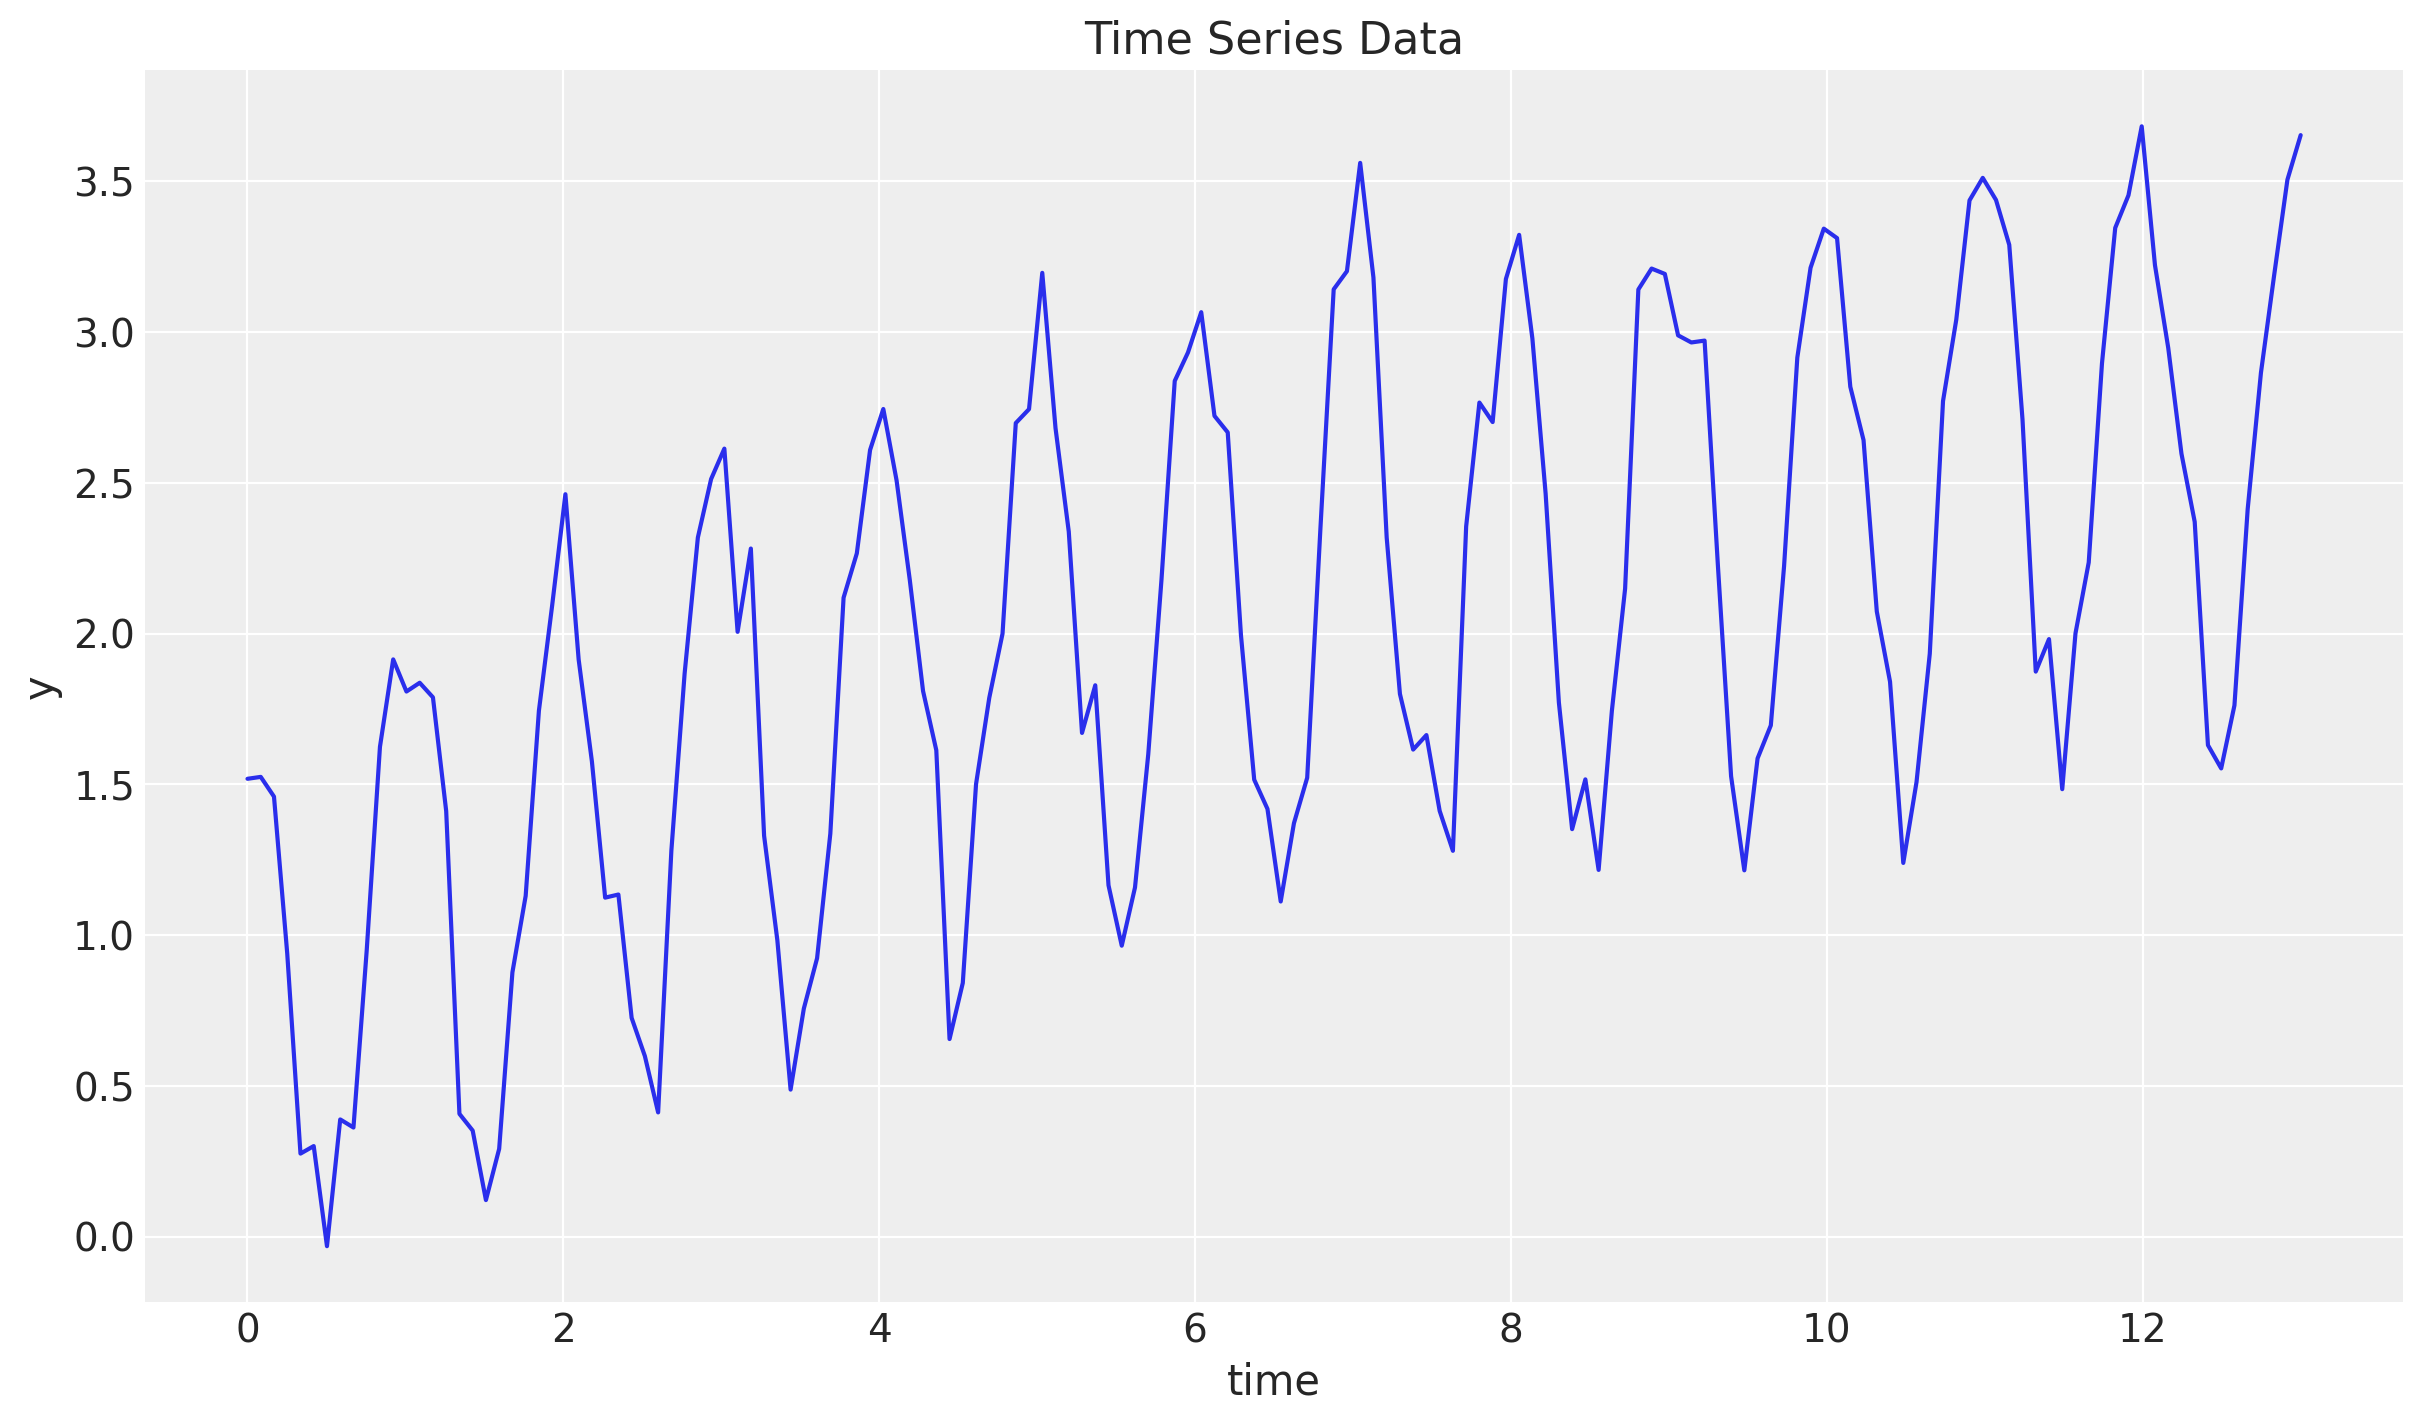

In [2]:
n_seasons = 12
t = jnp.linspace(start=0, stop=n_seasons + 1, num=(n_seasons + 1) * n_seasons)
y = jnp.cos(2 * jnp.pi * t) + jnp.log(t + 2) + 0.2 * random.normal(rng_key, t.shape)

fig, ax = plt.subplots()
ax.plot(t, y)
ax.set(xlabel="time", ylabel="y", title="Time Series Data")

## Train - Test Split

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Time Series Data Split')]

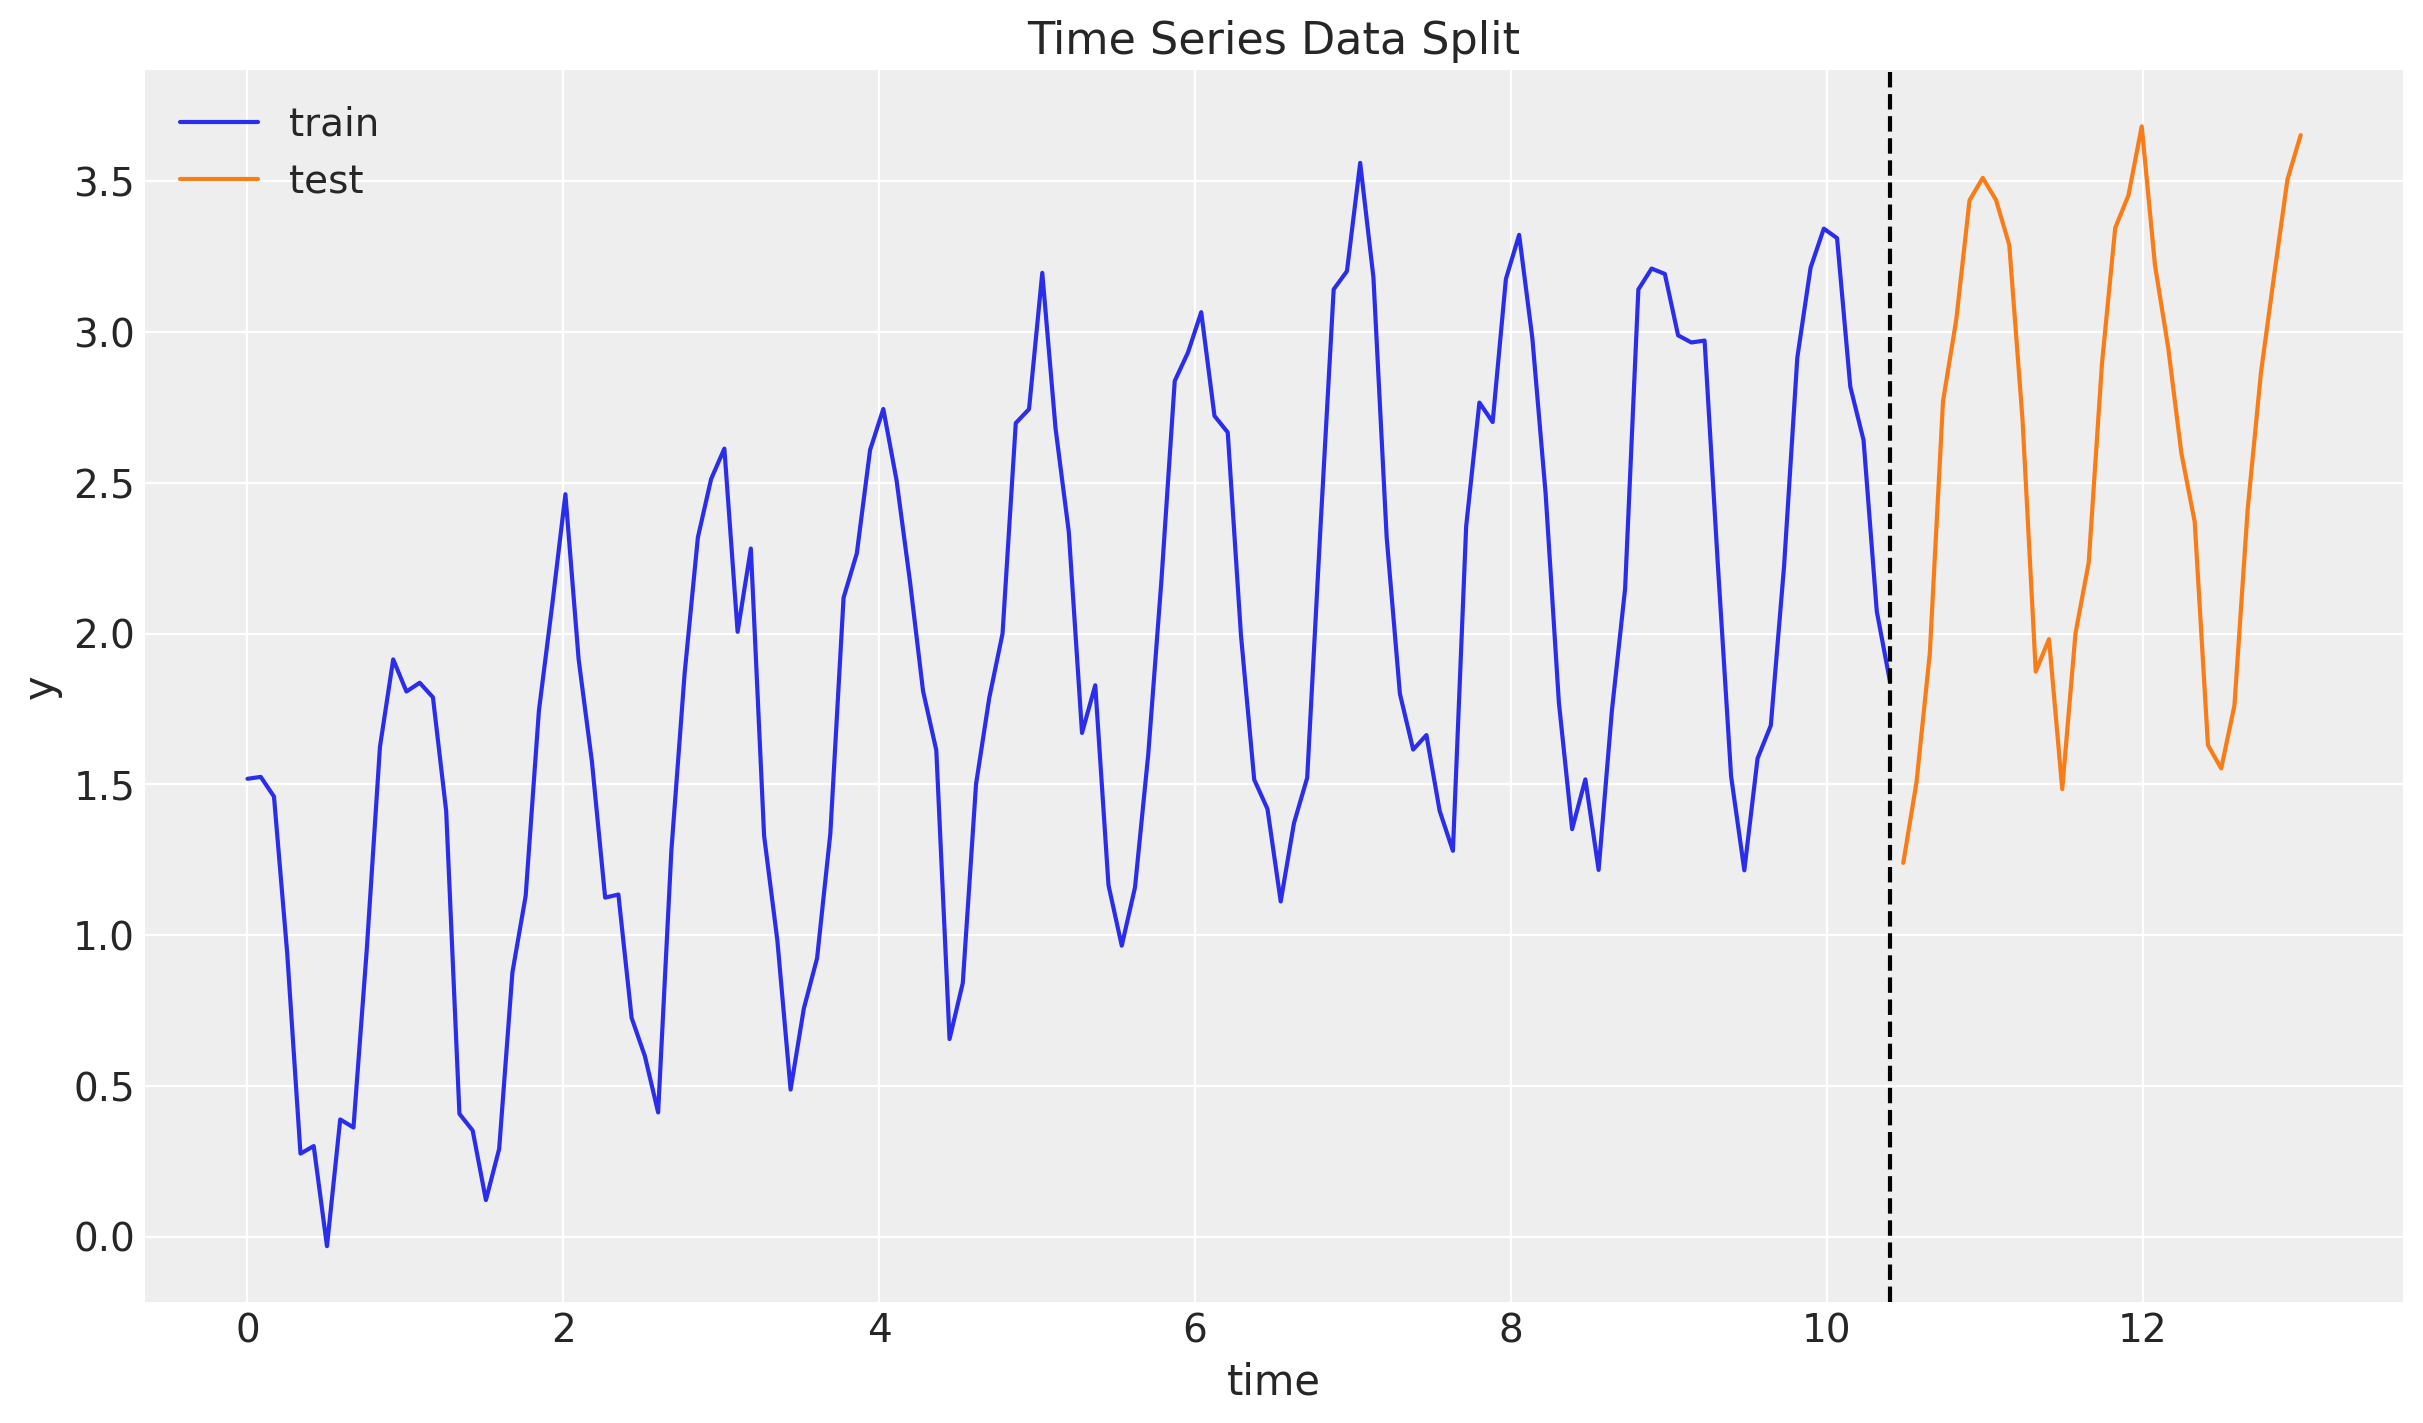

In [3]:
n = y.size

prop_train = 0.8
n_train = round(prop_train * n)

y_train = y[:n_train]
t_train = t[:n_train]

y_test = y[n_train:]
t_test = t[n_train:]

fig, ax = plt.subplots()
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="Time Series Data Split")

## Level Model

### Model Specification

In [4]:
def level_model(y: ArrayImpl, future: int = 0) -> None:
    # Get time series length
    t_max = y.shape[0]

    # --- Priors ---

    ## Level
    level_smoothing = numpyro.sample("level_smoothing", dist.Beta(1, 1))
    level_init = numpyro.sample("level_init", dist.Normal(0, 1))

    ## Noise
    noise = numpyro.sample("noise", dist.HalfNormal(1))

    # --- Transition Function ---

    def transition_fn(carry, t):
        previous_level = carry

        level = jnp.where(
            t < t_max,
            level_smoothing * y[t] + (1 - level_smoothing) * previous_level,
            previous_level,
        )

        mu = previous_level
        pred = numpyro.sample("pred", dist.Normal(mu, noise))

        return level, pred

    # --- Run Scan ---

    with numpyro.handlers.condition(data={"pred": y}):
        _, preds = scan(
            transition_fn,
            level_init,
            jnp.arange(t_max + future),
        )

    # --- Forecast ---
    if future > 0:
        numpyro.deterministic("y_forecast", preds[-future:])

### Inference

In [5]:
class InferenceParams(BaseModel):
    num_warmup: int = Field(2_000, ge=1)
    num_samples: int = Field(2_000, ge=1)
    num_chains: int = Field(4, ge=1)


def run_inference(
    rng_key: ArrayImpl, model: Callable, args: InferenceParams, *model_args
) -> MCMC:
    sampler = NUTS(model)
    mcmc = MCMC(
        sampler=sampler,
        num_warmup=args.num_warmup,
        num_samples=args.num_samples,
        num_chains=args.num_chains,
    )
    mcmc.run(rng_key, *model_args)
    return mcmc

In [6]:
inference_params = InferenceParams()
rng_key, rng_subkey = random.split(key=rng_key)
level_mcmc = run_inference(rng_subkey, level_model, inference_params, y_train)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [7]:
level_idata = az.from_numpyro(posterior=level_mcmc)

az.summary(data=level_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
level_init,1.263,0.416,0.505,2.053,0.005,0.004,6198.0,5136.0,1.0
level_smoothing,0.982,0.017,0.950,1.000,0.000,0.000,5402.0,3447.0,1.0
noise,0.455,0.029,0.405,0.511,0.000,0.000,6672.0,5331.0,1.0


In [8]:
print(f"""Divergences: {level_idata["sample_stats"]["diverging"].sum().item()}""")

Divergences: 0


Text(0.5, 0.98, 'Level Model Trace')

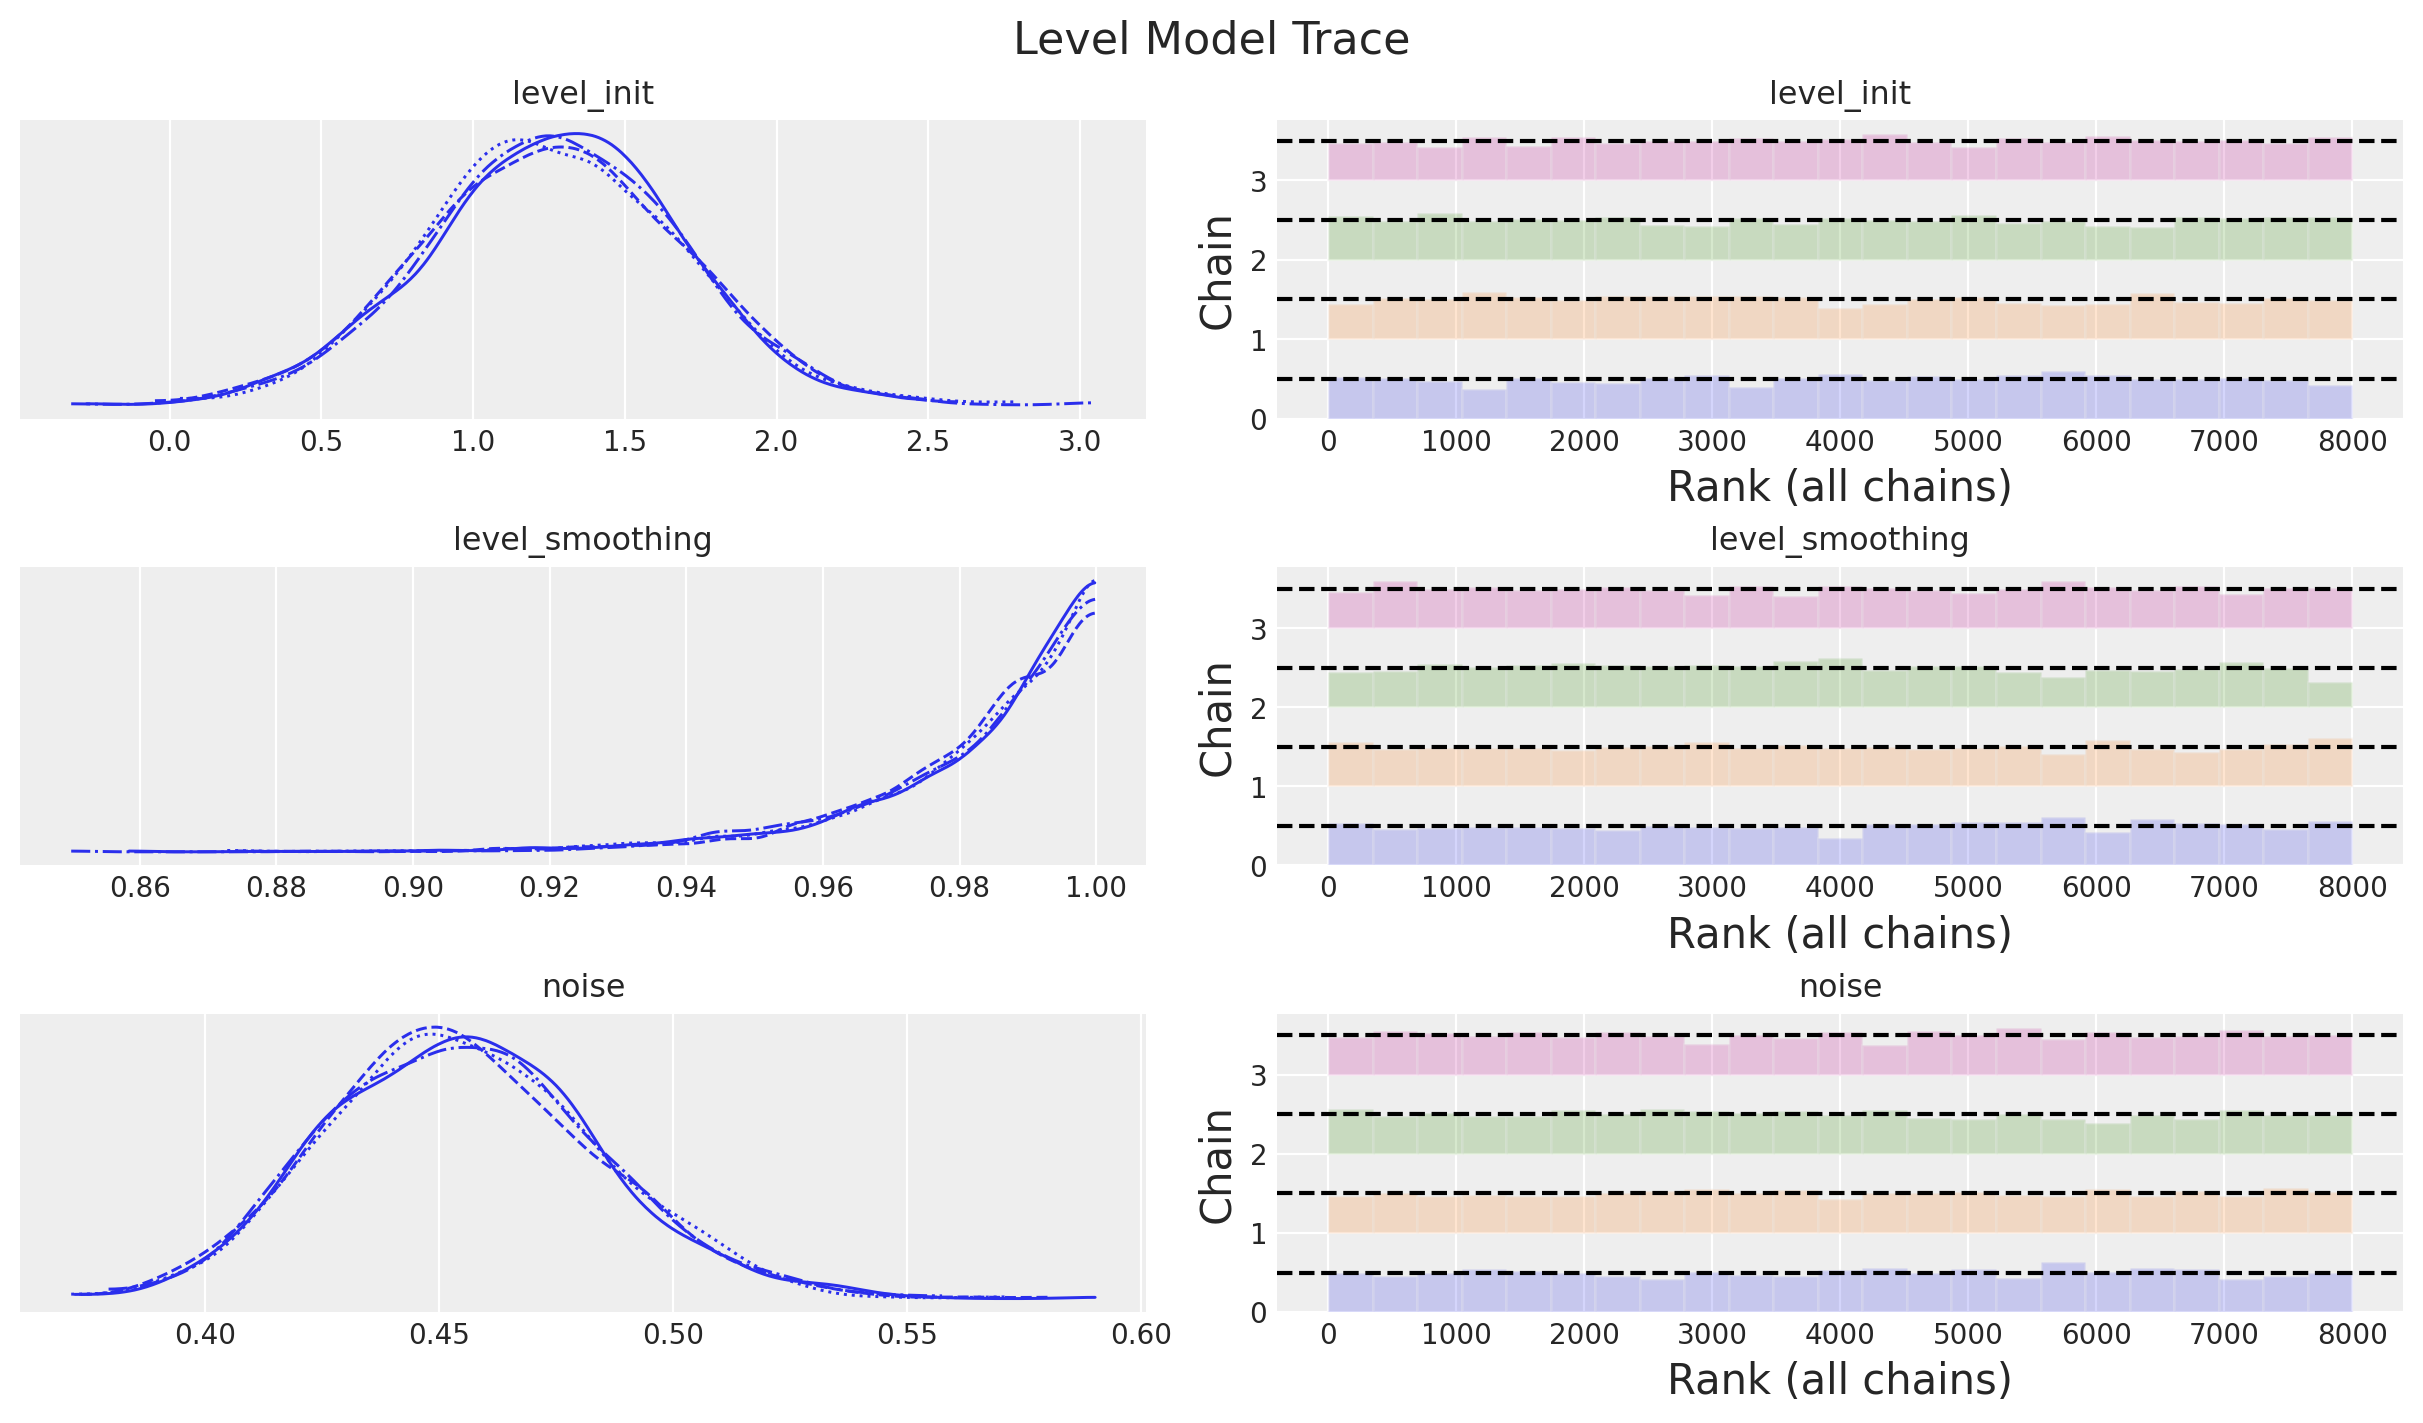

In [9]:
axes = az.plot_trace(
    data=level_idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 7), "layout": "constrained"},
)
plt.gcf().suptitle("Level Model Trace", fontsize=16)

### Forecast

In [10]:
def forecast(
    rng_key: ArrayImpl, model: Callable, samples: dict[str, ArrayImpl], *model_args
) -> dict[str, ArrayImpl]:
    predictive = Predictive(
        model=model,
        posterior_samples=samples,
        return_sites=["y_forecast"],
    )
    return predictive(rng_key, *model_args)

In [11]:
rng_key, rng_subkey = random.split(key=rng_key)
level_forecast = forecast(
    rng_subkey, level_model, level_mcmc.get_samples(), y_train, y_test.size
)

In [12]:
level_posterior_predictive = az.from_numpyro(
    posterior_predictive=level_forecast,
    coords={"t": range(n_train, n)},
    dims={"y_forecast": ["t"]},
)

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Level Model Forecast')]

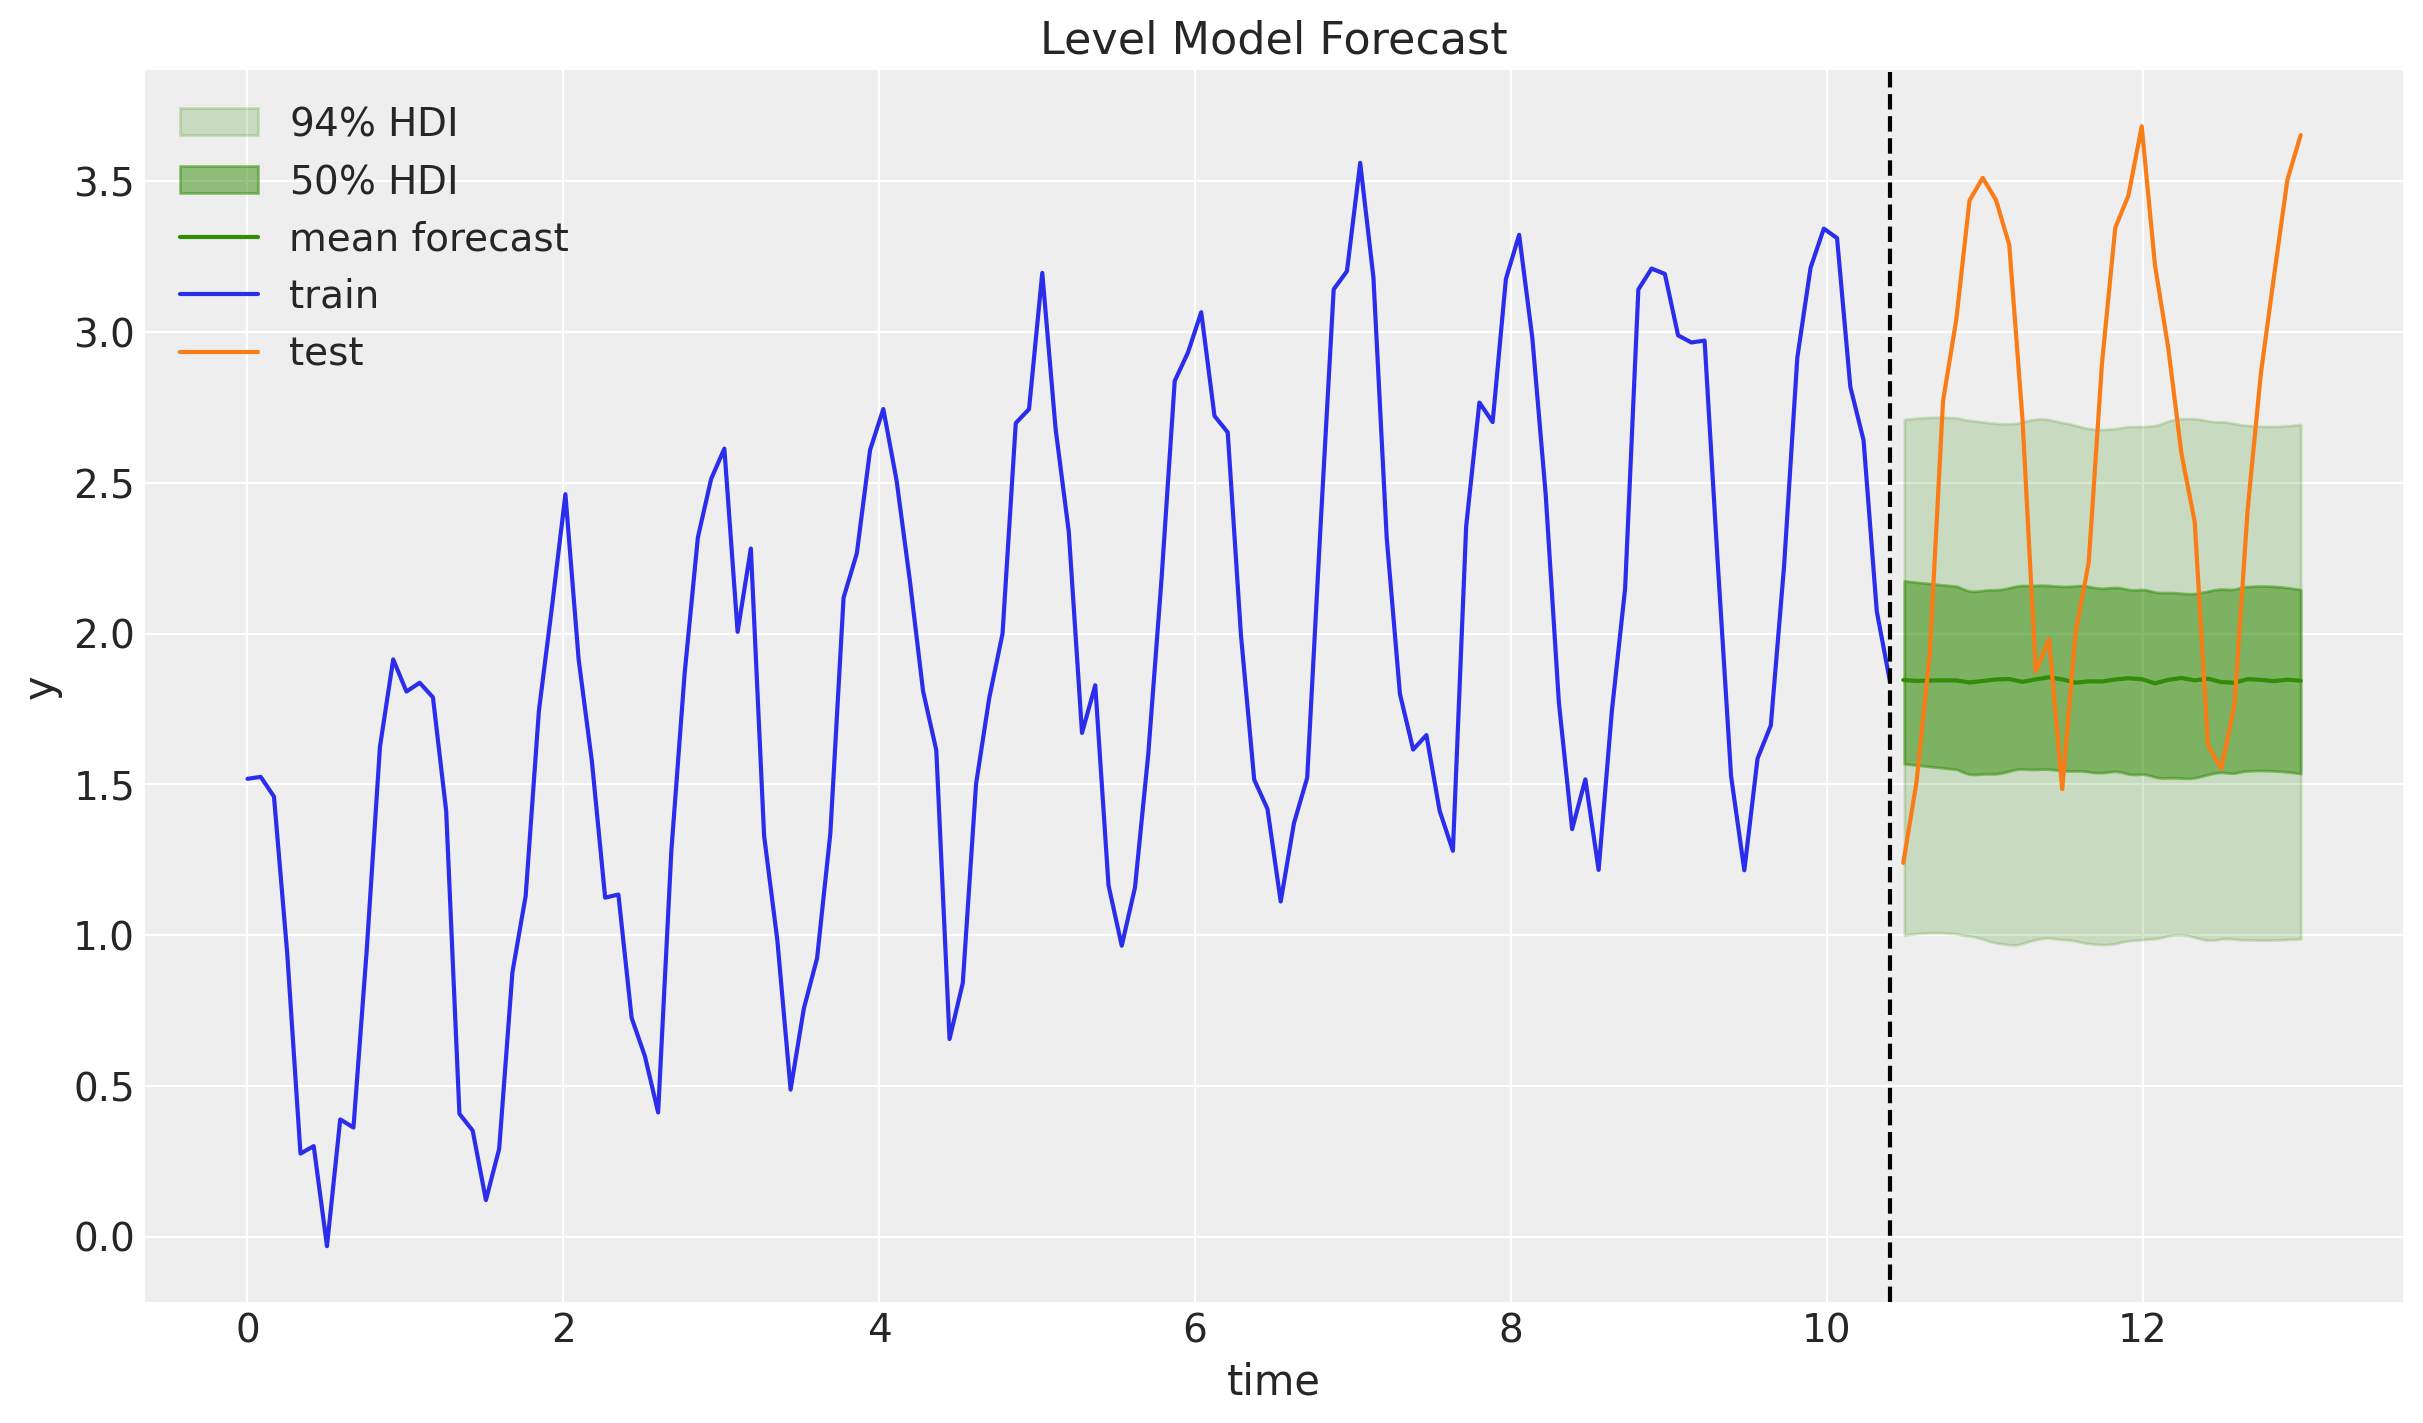

In [13]:
fig, ax = plt.subplots()
az.plot_hdi(
    x=t_test,
    y=level_posterior_predictive["posterior_predictive"]["y_forecast"],
    hdi_prob=0.94,
    color="C2",
    fill_kwargs={"alpha": 0.2, "label": r"$94\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    x=t_test,
    y=level_posterior_predictive["posterior_predictive"]["y_forecast"],
    hdi_prob=0.50,
    color="C2",
    fill_kwargs={"alpha": 0.5, "label": r"$50\%$ HDI"},
    ax=ax,
)
ax.plot(
    t_test,
    level_posterior_predictive["posterior_predictive"]["y_forecast"].mean(
        dim=("chain", "draw")
    ),
    color="C2",
    label="mean forecast",
)
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="Level Model Forecast")

## Level + Trend Model

### Model Specification

In [14]:
def level_trend_model(y: ArrayImpl, future: int = 0) -> None:
    # Get time series length
    t_max = y.shape[0]

    # --- Priors ---

    ## Level
    level_smoothing = numpyro.sample("level_smoothing", dist.Beta(1, 1))
    level_init = numpyro.sample("level_init", dist.Normal(0, 1))

    ## Trend
    trend_smoothing = numpyro.sample("trend_smoothing", dist.Beta(1, 1))
    trend_init = numpyro.sample("trend_init", dist.Normal(0, 1))

    ## Noise
    noise = numpyro.sample("noise", dist.HalfNormal(1))

    # --- Transition Function ---

    def transition_fn(carry, t):
        previous_level, previous_trend = carry

        level = jnp.where(
            t < t_max,
            level_smoothing * y[t]
            + (1 - level_smoothing) * (previous_level + previous_trend),
            previous_level,
        )

        trend = jnp.where(
            t < t_max,
            trend_smoothing * (level - previous_level)
            + (1 - trend_smoothing) * previous_trend,
            previous_trend,
        )

        step = jnp.where(t < t_max, 1, t - t_max + 1)

        mu = previous_level + step * previous_trend
        pred = numpyro.sample("pred", dist.Normal(mu, noise))

        return (level, trend), pred

    # --- Run Scan ---

    with numpyro.handlers.condition(data={"pred": y}):
        _, preds = scan(
            transition_fn,
            (level_init, trend_init),
            jnp.arange(t_max + future),
        )

    # --- Forecast ---
    if future > 0:
        numpyro.deterministic("y_forecast", preds[-future:])

### Inference

In [15]:
rng_key, rng_subkey = random.split(key=rng_key)
level_trend_mcmc = run_inference(
    rng_subkey, level_trend_model, inference_params, y_train
)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [16]:
level_trend_idata = az.from_numpyro(posterior=level_trend_mcmc)

az.summary(data=level_trend_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
level_init,1.306,0.404,0.536,2.074,0.006,0.004,5272.0,4434.0,1.0
level_smoothing,0.887,0.061,0.791,1.000,0.001,0.001,4045.0,2562.0,1.0
noise,0.456,0.030,0.400,0.513,0.000,0.000,5697.0,5121.0,1.0
trend_init,0.133,0.451,-0.694,0.979,0.006,0.005,5329.0,4843.0,1.0
trend_smoothing,0.819,0.124,0.616,1.000,0.003,0.002,3622.0,3335.0,1.0


In [17]:
print(f"""Divergences: {level_trend_idata["sample_stats"]["diverging"].sum().item()}""")

Divergences: 0


Text(0.5, 0.98, 'Level + Trend Model Trace')

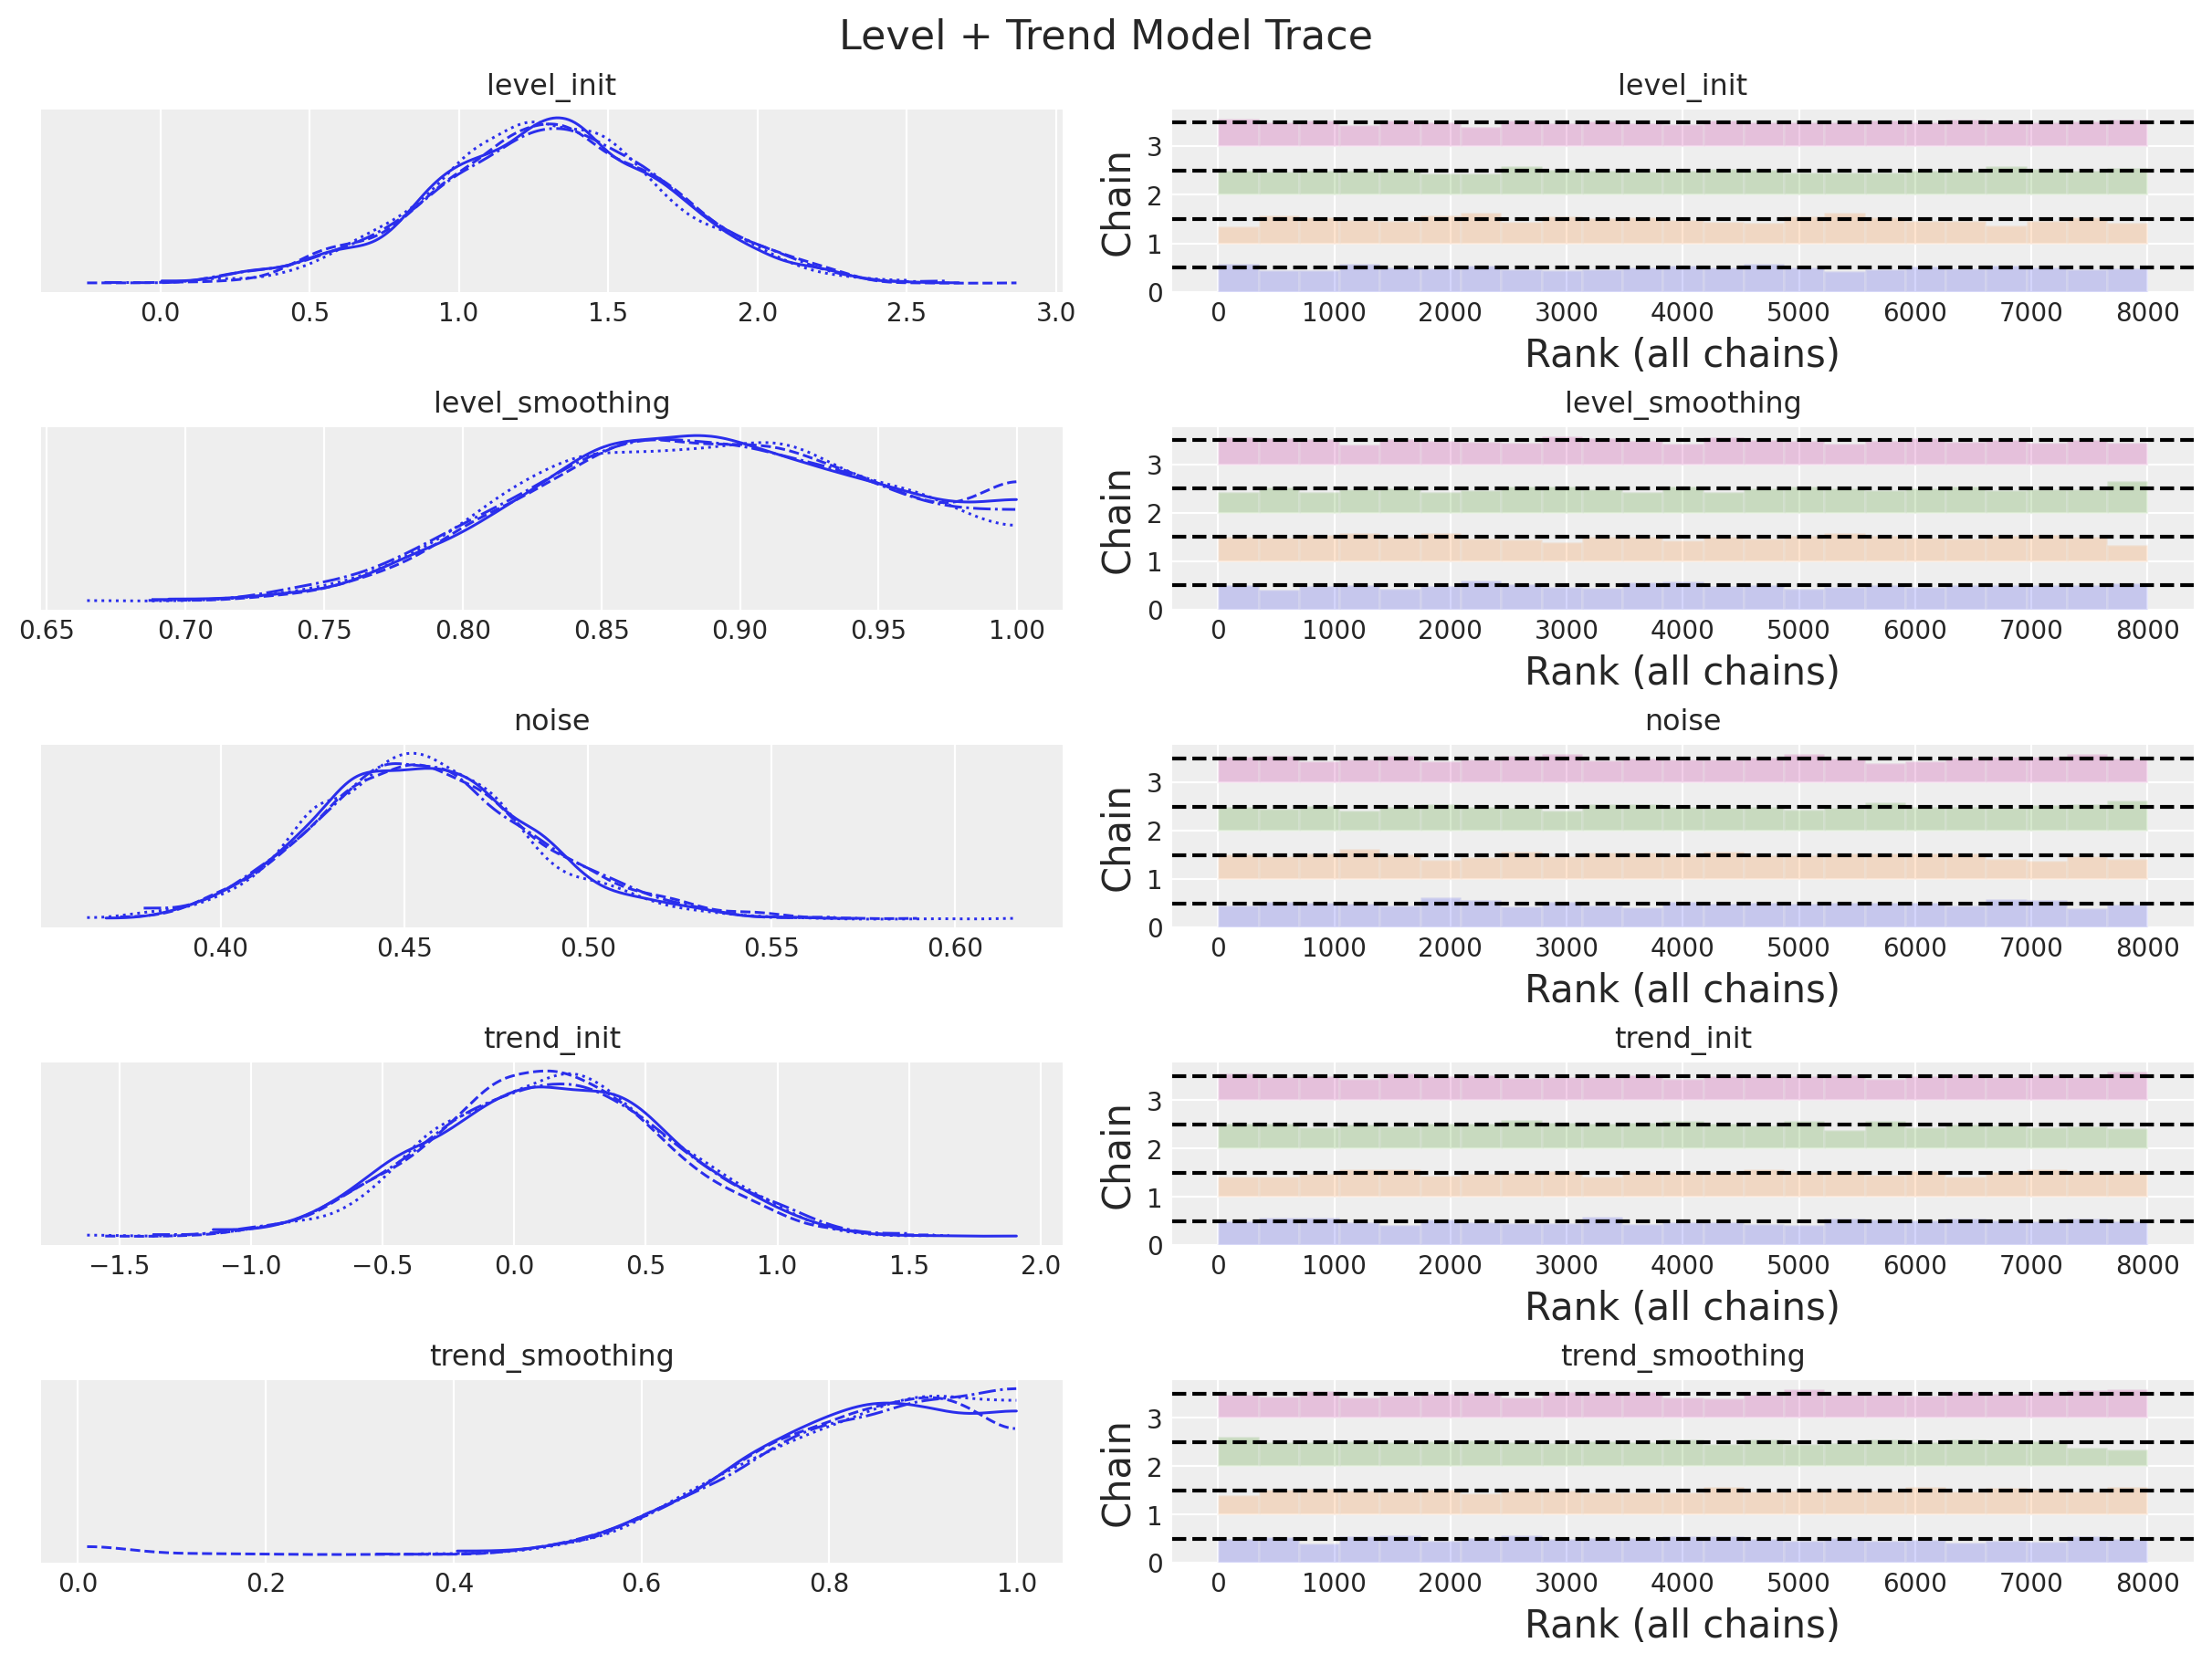

In [18]:
axes = az.plot_trace(
    data=level_trend_idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Level + Trend Model Trace", fontsize=16)

### Forecast

In [19]:
rng_key, rng_subkey = random.split(key=rng_key)
level_trend_forecast = forecast(
    rng_subkey, level_trend_model, level_trend_mcmc.get_samples(), y_train, y_test.size
)

level_trend_posterior_predictive = az.from_numpyro(
    posterior_predictive=level_trend_forecast,
    coords={"t": range(n_train, n)},
    dims={"y_forecast": ["t"]},
)

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Level + Trend Model Forecast')]

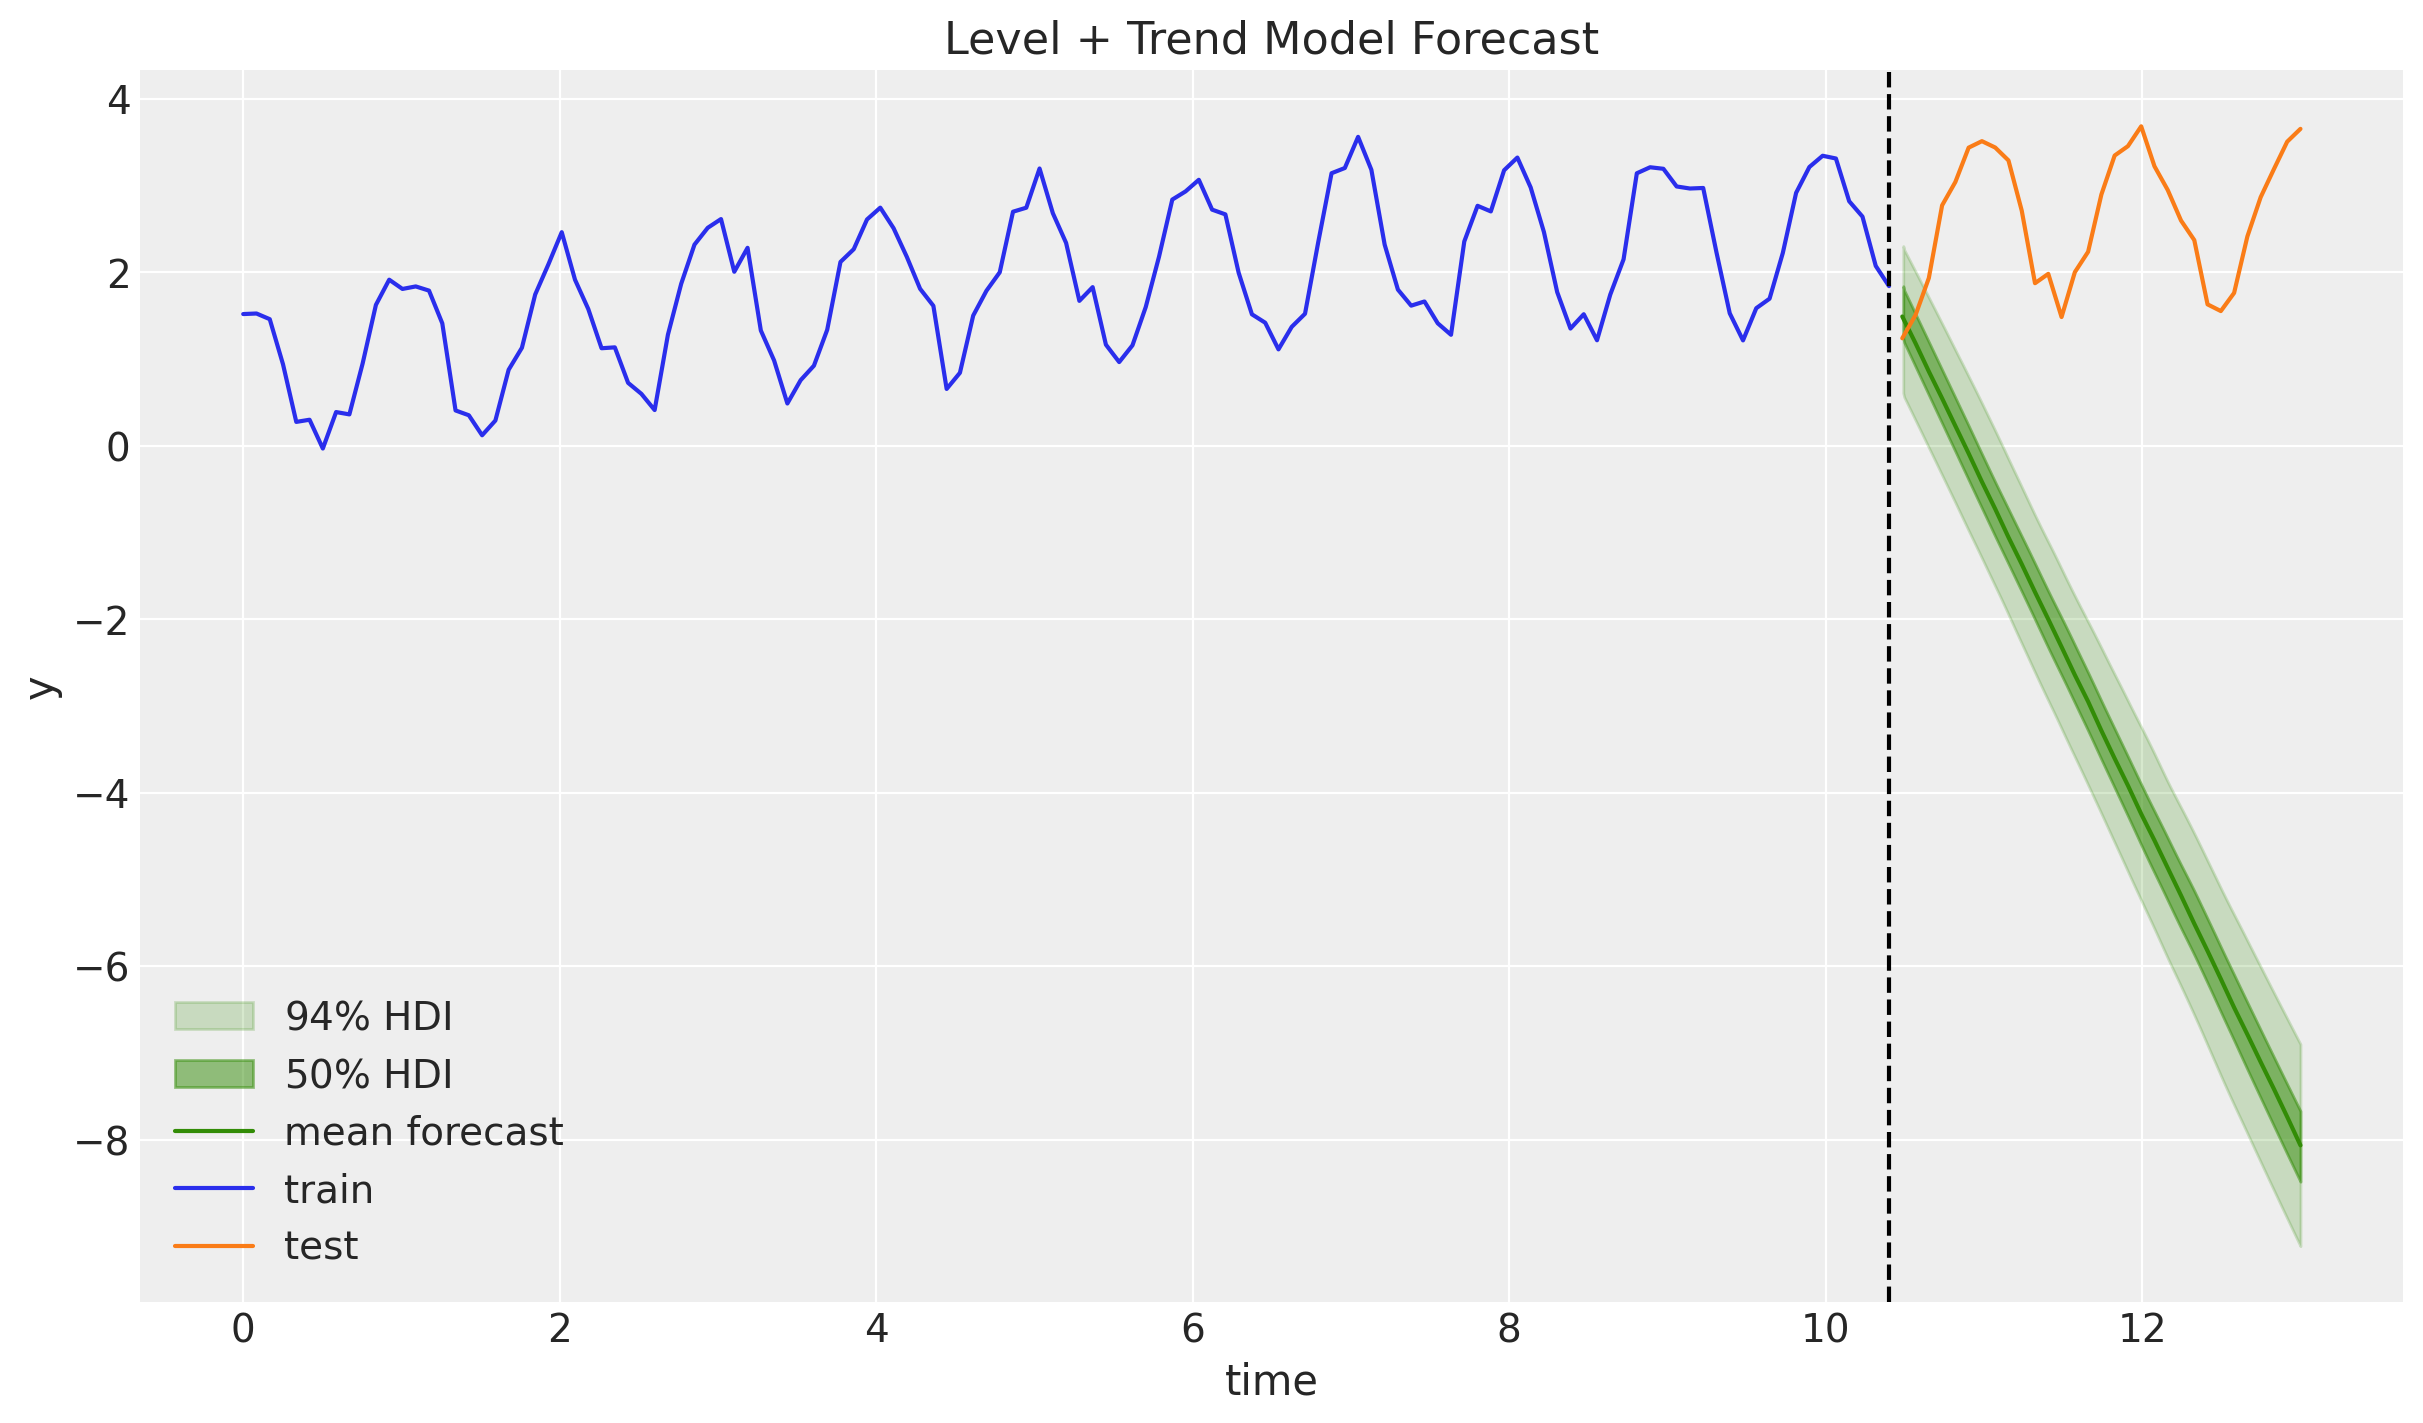

In [20]:
fig, ax = plt.subplots()
az.plot_hdi(
    x=t_test,
    y=level_trend_posterior_predictive["posterior_predictive"]["y_forecast"],
    hdi_prob=0.94,
    color="C2",
    fill_kwargs={"alpha": 0.2, "label": r"$94\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    x=t_test,
    y=level_trend_posterior_predictive["posterior_predictive"]["y_forecast"],
    hdi_prob=0.50,
    color="C2",
    fill_kwargs={"alpha": 0.5, "label": r"$50\%$ HDI"},
    ax=ax,
)
ax.plot(
    t_test,
    level_trend_posterior_predictive["posterior_predictive"]["y_forecast"].mean(
        dim=("chain", "draw")
    ),
    color="C2",
    label="mean forecast",
)
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="Level + Trend Model Forecast")

## Level + Trend + Seasonality Model (Holt-Winters)

### Model Specification

In [21]:
def holt_winters_model(y: ArrayImpl, n_seasons: int, future: int = 0) -> None:
    # Get time series length
    t_max = y.shape[0]

    # --- Priors ---

    ## Level
    level_smoothing = numpyro.sample("level_smoothing", dist.Beta(1, 1))
    level_init = numpyro.sample("level_init", dist.Normal(0, 1))

    ## Trend
    trend_smoothing = numpyro.sample("trend_smoothing", dist.Beta(1, 1))
    trend_init = numpyro.sample("trend_init", dist.Normal(0, 1))

    ## Seasonality
    seasonality_smoothing = numpyro.sample("seasonality_smoothing", dist.Beta(1, 1))
    adj_seasonality_smoothing = seasonality_smoothing * (1 - level_smoothing)

    with numpyro.plate("n_seasons", n_seasons):
        seasonality_init = numpyro.sample("seasonality_init", dist.Normal(0, 1))

    ## Noise
    noise = numpyro.sample("noise", dist.HalfNormal(1))

    # --- Transition Function ---

    def transition_fn(carry, t):
        previous_level, previous_trend, previous_seasonality = carry

        level = jnp.where(
            t < t_max,
            level_smoothing * (y[t] - previous_seasonality[0])
            + (1 - level_smoothing) * (previous_level + previous_trend),
            previous_level,
        )

        trend = jnp.where(
            t < t_max,
            trend_smoothing * (level - previous_level)
            + (1 - trend_smoothing) * previous_trend,
            previous_trend,
        )

        new_season = jnp.where(
            t < t_max,
            adj_seasonality_smoothing * (y[t] - (previous_level + previous_trend))
            + (1 - adj_seasonality_smoothing) * previous_seasonality[0],
            previous_seasonality[0],
        )

        step = jnp.where(t < t_max, 1, t - t_max + 1)

        mu = previous_level + step * previous_trend + previous_seasonality[0]
        pred = numpyro.sample("pred", dist.Normal(mu, noise))

        seasonality = jnp.concatenate(
            [previous_seasonality[1:], new_season[None]], axis=0
        )

        return (level, trend, seasonality), pred

    # --- Run Scan ---

    with numpyro.handlers.condition(data={"pred": y}):
        _, preds = scan(
            transition_fn,
            (level_init, trend_init, seasonality_init),
            jnp.arange(t_max + future),
        )

    # --- Forecast ---
    if future > 0:
        numpyro.deterministic("y_forecast", preds[-future:])

### Inference

In [22]:
rng_key, rng_subkey = random.split(key=rng_key)
holt_winters_mcmc = run_inference(
    rng_subkey, holt_winters_model, inference_params, y_train, n_seasons
)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [23]:
holt_winters_idata = az.from_numpyro(posterior=holt_winters_mcmc)

az.summary(data=holt_winters_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
level_init,0.740,0.283,0.215,1.282,0.009,0.006,1007.0,1584.0,1.0
level_smoothing,0.029,0.026,0.004,0.074,0.000,0.000,2649.0,4635.0,1.0
noise,0.239,0.017,0.207,0.270,0.000,0.000,4025.0,5127.0,1.0
seasonality_init[0],0.898,0.322,0.303,1.521,0.009,0.007,1226.0,2075.0,1.0
seasonality_init[1],0.668,0.314,0.070,1.249,0.009,0.006,1236.0,1945.0,1.0
seasonality_init[2],0.520,0.318,-0.094,1.099,0.009,0.006,1287.0,1985.0,1.0
seasonality_init[3],-0.019,0.321,-0.645,0.564,0.009,0.006,1356.0,2324.0,1.0
seasonality_init[4],-0.515,0.316,-1.106,0.081,0.009,0.006,1232.0,2141.0,1.0
seasonality_init[5],-0.748,0.318,-1.338,-0.156,0.009,0.006,1317.0,2113.0,1.0
seasonality_init[6],-0.918,0.319,-1.498,-0.307,0.009,0.006,1289.0,2164.0,1.0


In [24]:
print(
    f"""Divergences: {holt_winters_idata["sample_stats"]["diverging"].sum().item()}"""
)

Divergences: 0


Text(0.5, 0.98, 'Holt Winters Trace')

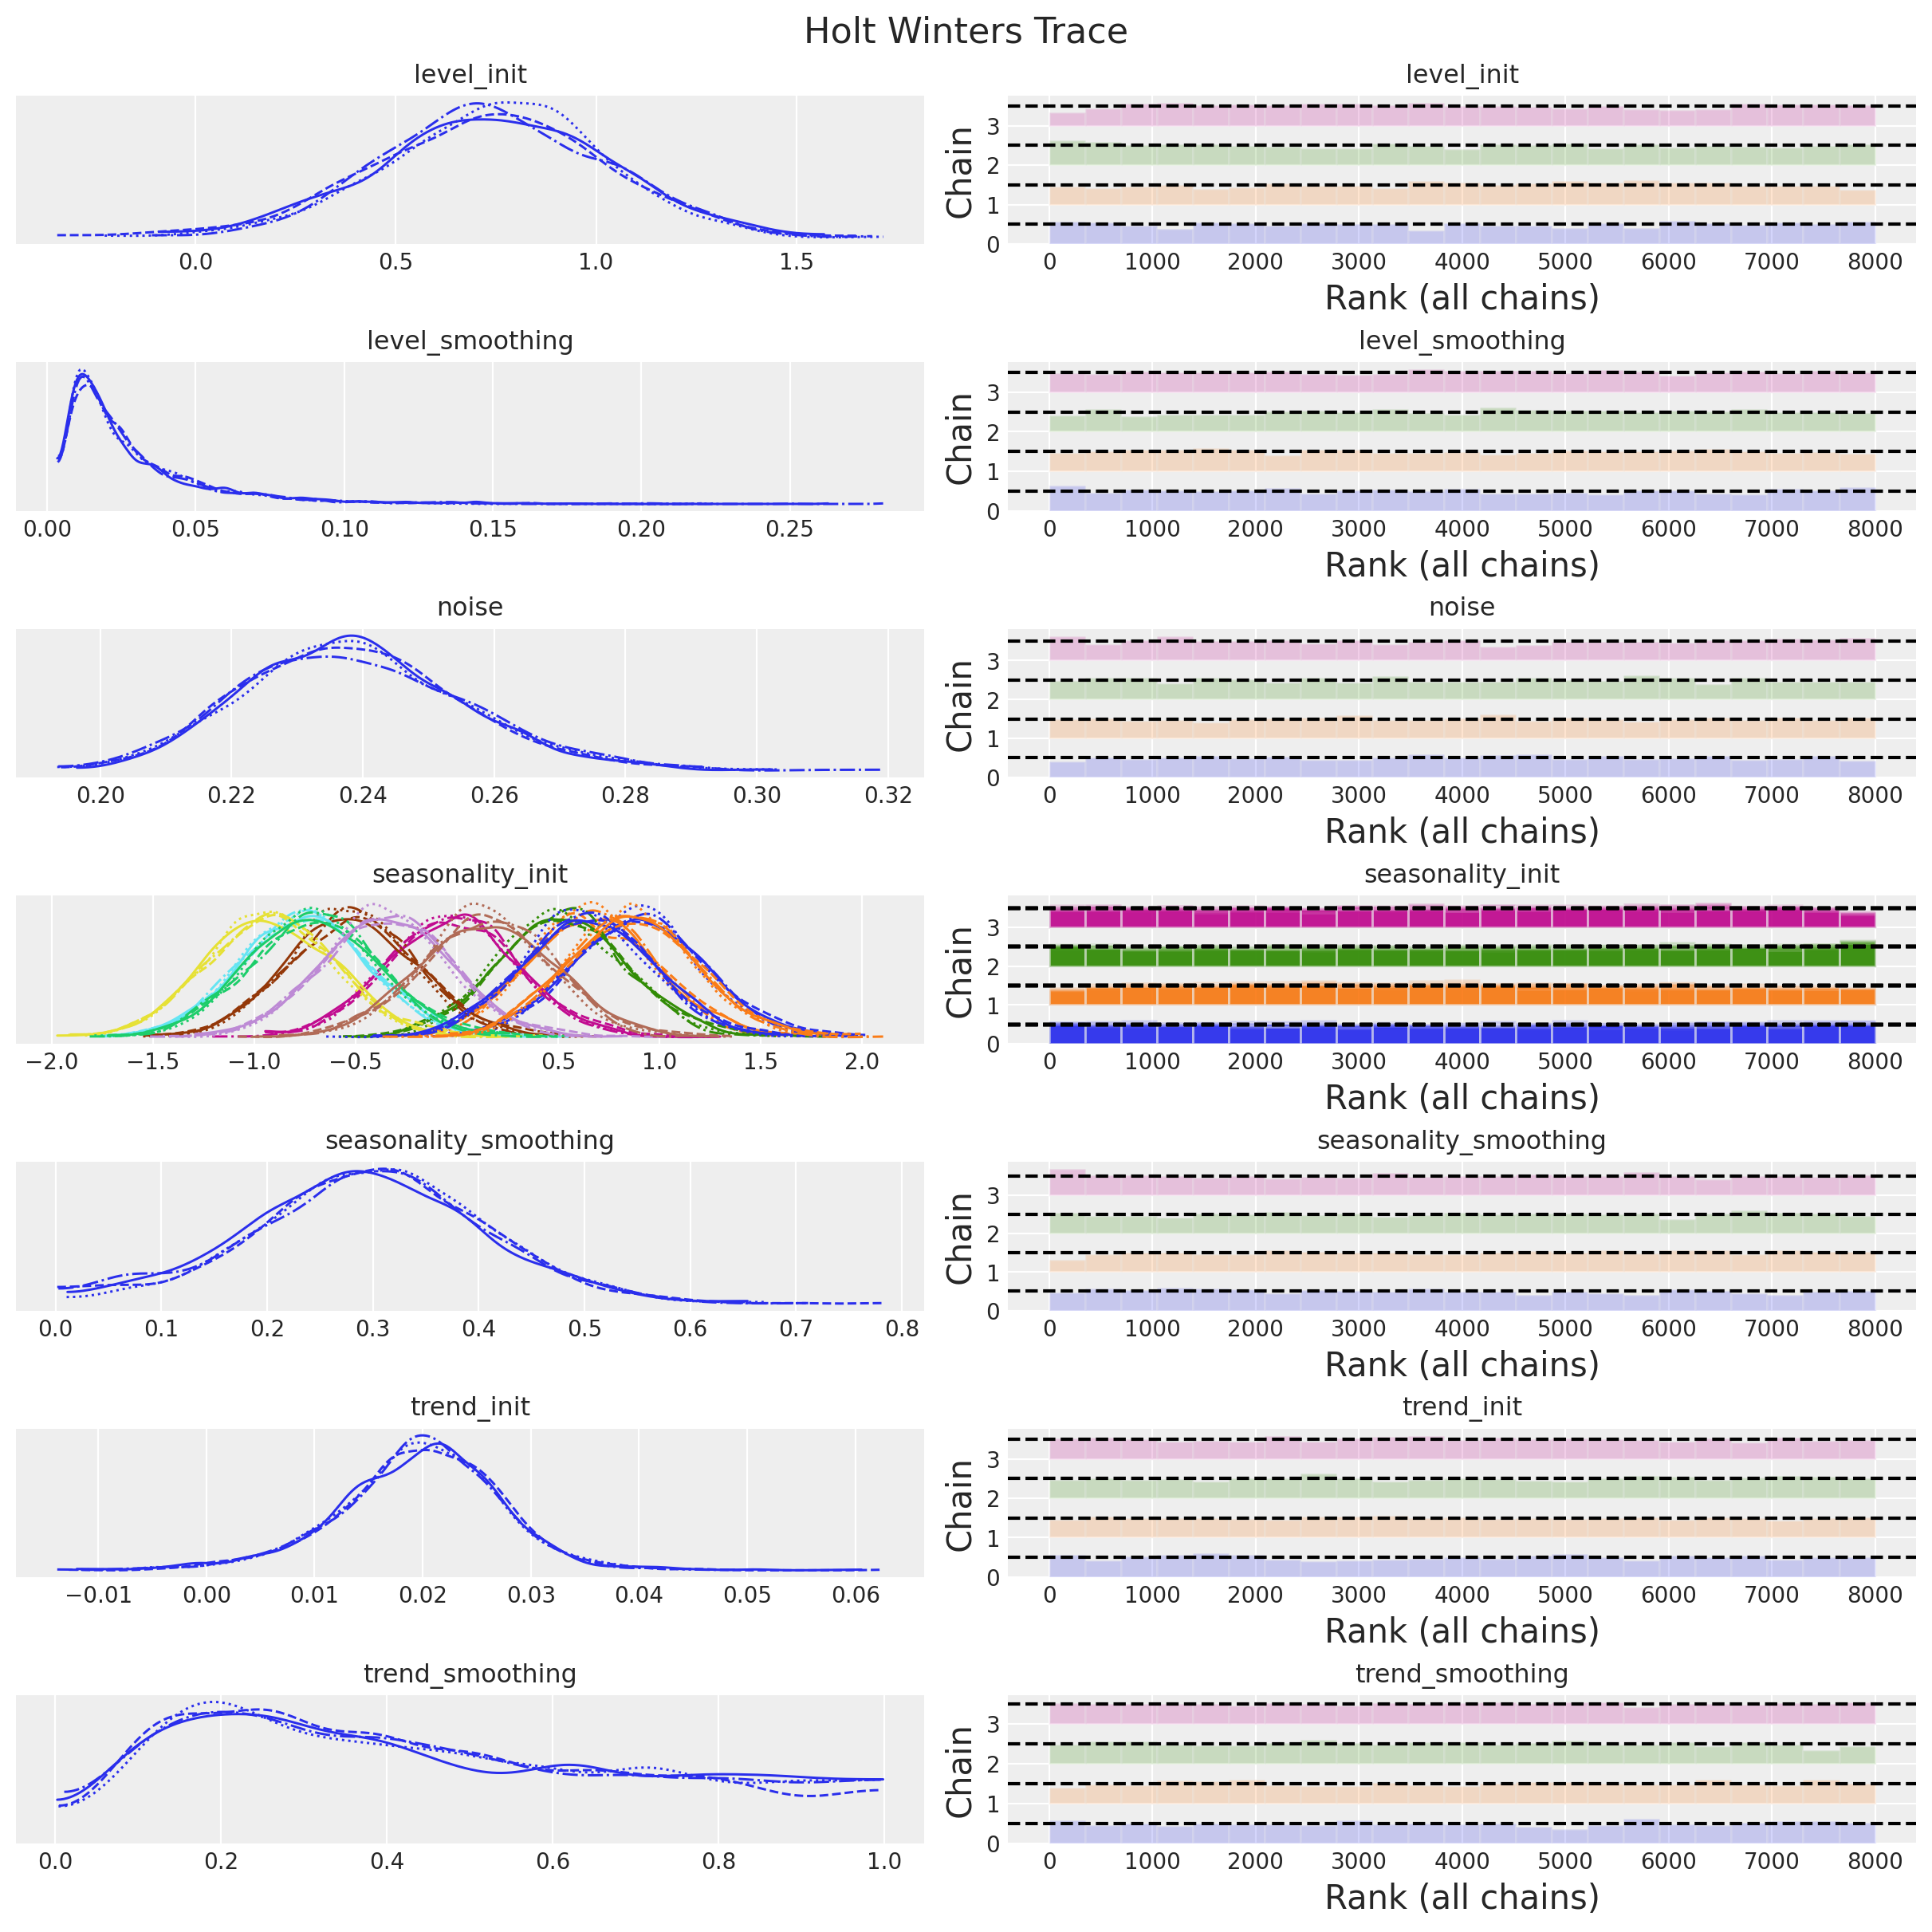

In [25]:
axes = az.plot_trace(
    data=holt_winters_idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 12), "layout": "constrained"},
)
plt.gcf().suptitle("Holt Winters Trace", fontsize=16)

### Forecast

In [26]:
rng_key, rng_subkey = random.split(key=rng_key)
holt_winters_forecast = forecast(
    rng_subkey,
    holt_winters_model,
    holt_winters_mcmc.get_samples(),
    y_train,
    n_seasons,
    y_test.size,
)

holt_winters_posterior_predictive = az.from_numpyro(
    posterior_predictive=holt_winters_forecast,
    coords={"t": range(n_train, n)},
    dims={"y_forecast": ["t"]},
)

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Holt Winters Model Forecast')]

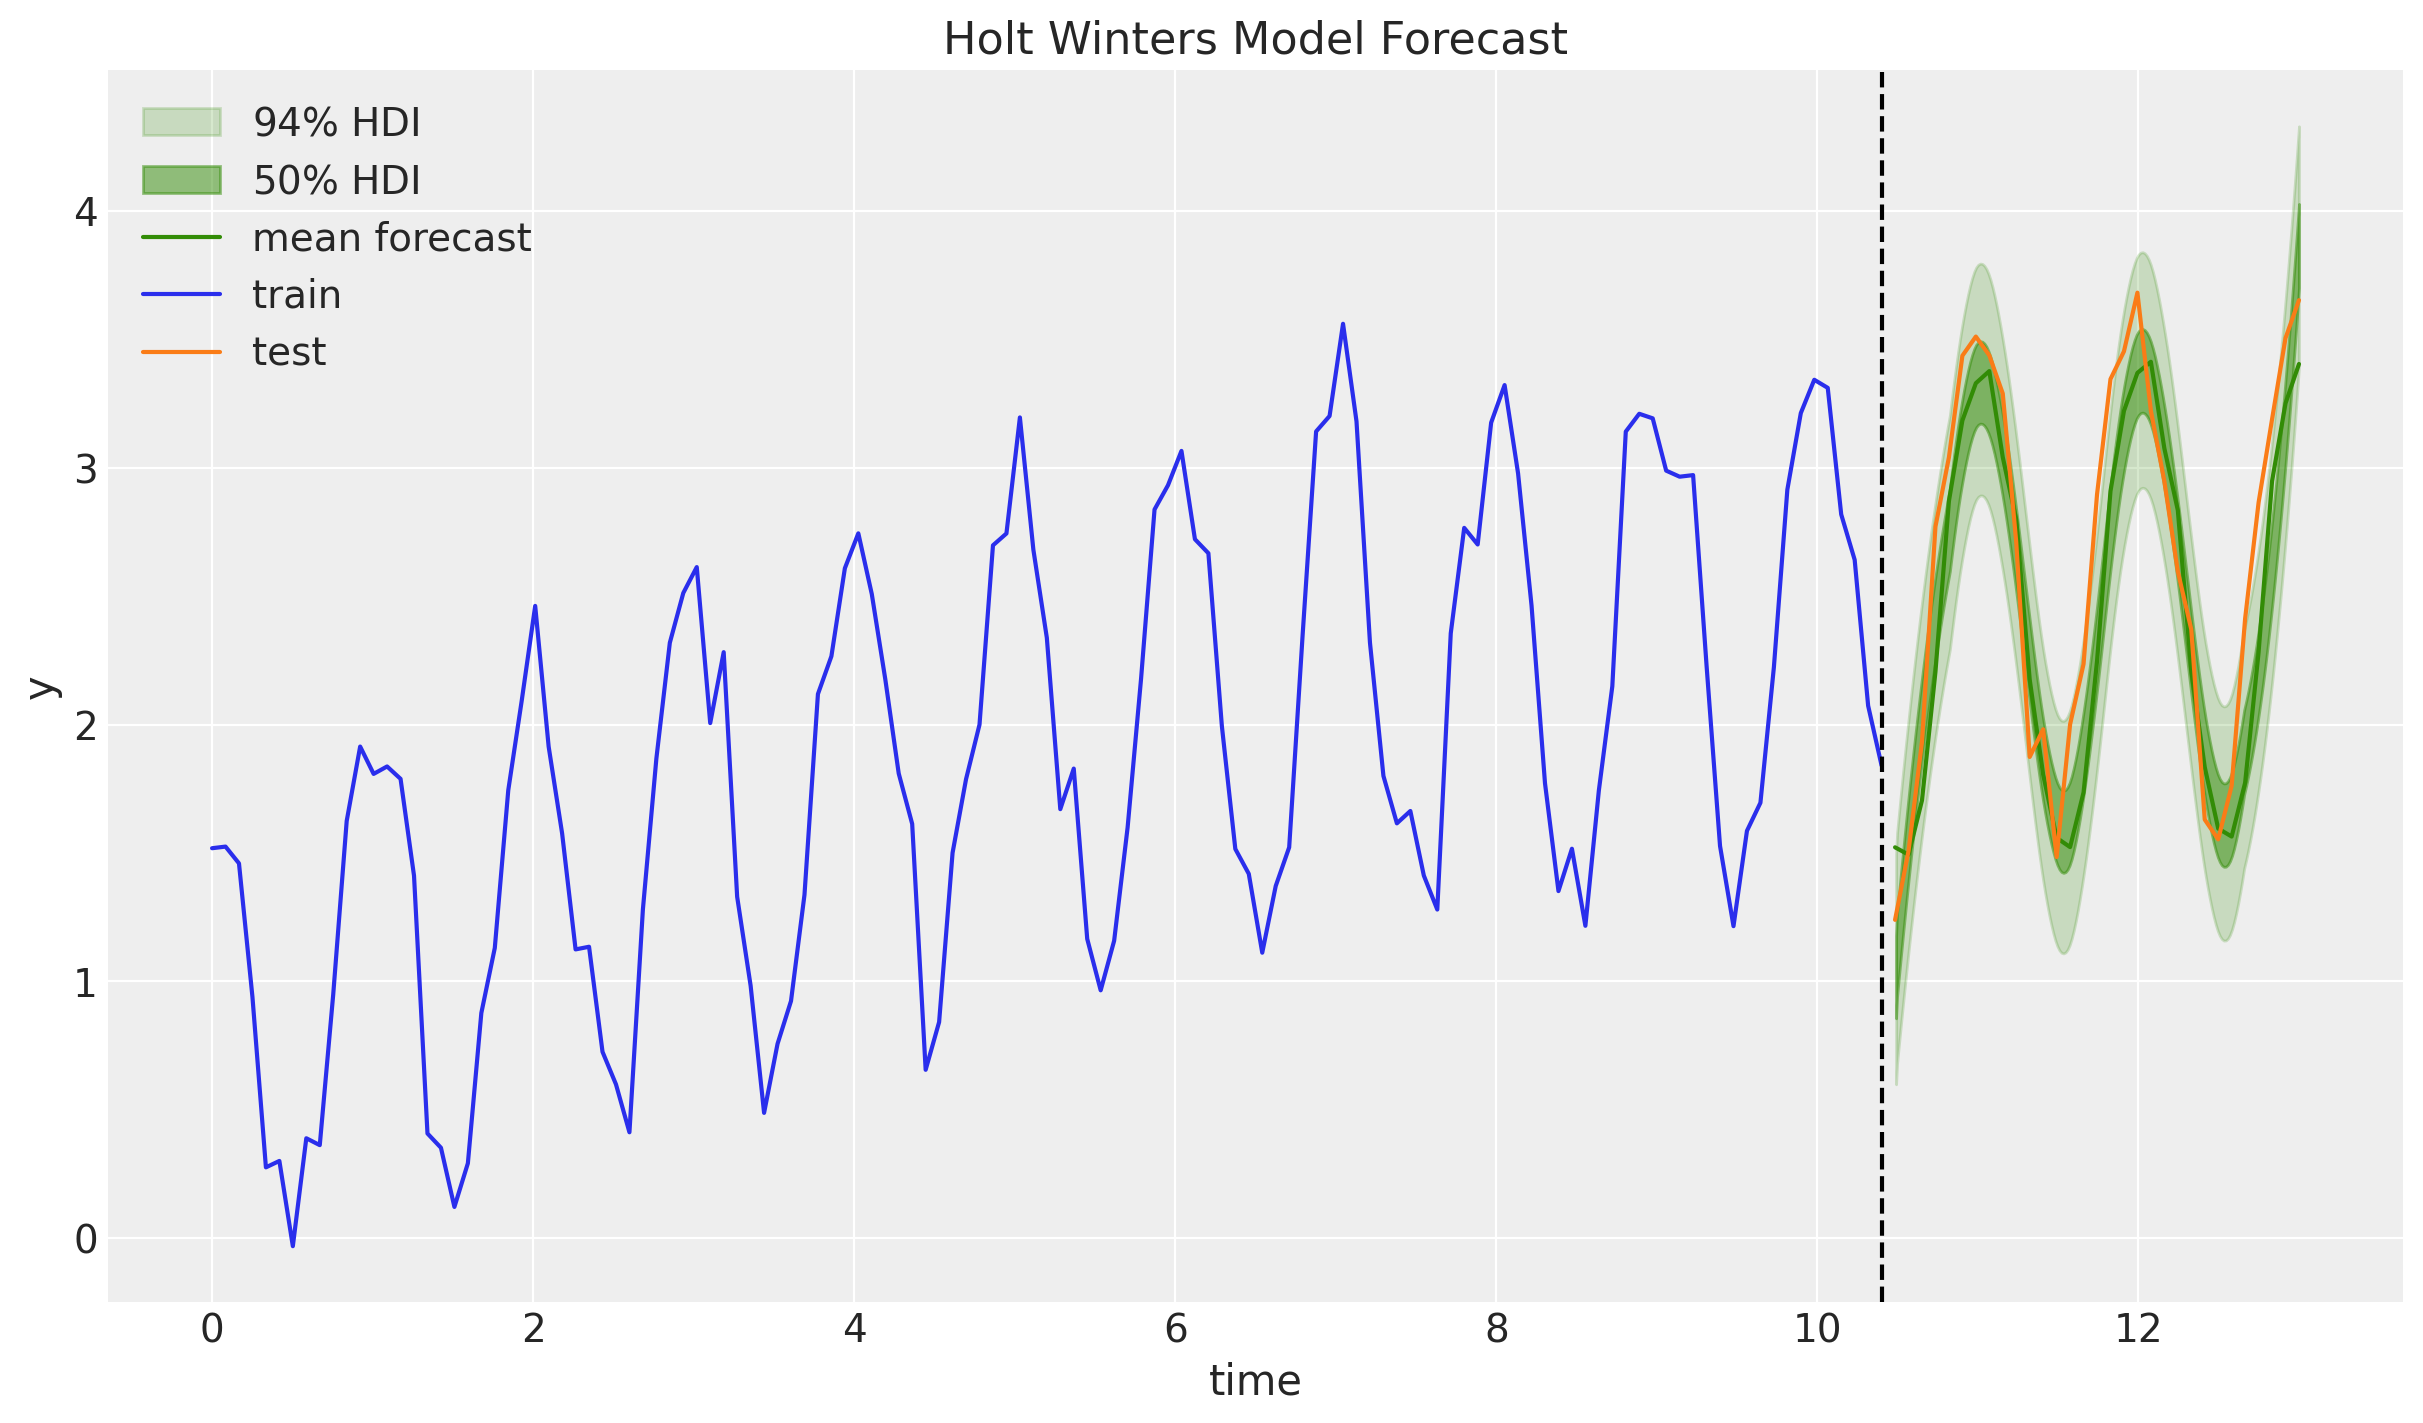

In [27]:
fig, ax = plt.subplots()
az.plot_hdi(
    x=t_test,
    y=holt_winters_posterior_predictive["posterior_predictive"]["y_forecast"],
    hdi_prob=0.94,
    color="C2",
    fill_kwargs={"alpha": 0.2, "label": r"$94\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    x=t_test,
    y=holt_winters_posterior_predictive["posterior_predictive"]["y_forecast"],
    hdi_prob=0.50,
    color="C2",
    fill_kwargs={"alpha": 0.5, "label": r"$50\%$ HDI"},
    ax=ax,
)
ax.plot(
    t_test,
    holt_winters_posterior_predictive["posterior_predictive"]["y_forecast"].mean(
        dim=("chain", "draw")
    ),
    color="C2",
    label="mean forecast",
)
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="Holt Winters Model Forecast")

## Level + Trend + Seasonality Model (Holt-Winters)

### Model Specification

In [ ]:
def holt_winters_model(y: ArrayImpl, n_seasons: int, future: int = 0) -> None:
    # Get time series length
    t_max = y.shape[0]

    # --- Priors ---

    ## Level
    level_smoothing = numpyro.sample("level_smoothing", dist.Beta(1, 1))
    level_init = numpyro.sample("level_init", dist.Normal(0, 1))

    ## Trend
    trend_smoothing = numpyro.sample("trend_smoothing", dist.Beta(1, 1))
    trend_init = numpyro.sample("trend_init", dist.Normal(0, 1))

    ## Seasonality
    seasonality_smoothing = numpyro.sample("seasonality_smoothing", dist.Beta(1, 1))
    adj_seasonality_smoothing = seasonality_smoothing * (1 - level_smoothing)

    with numpyro.plate("n_seasons", n_seasons):
        seasonality_init = numpyro.sample("seasonality_init", dist.Normal(0, 1))

    ## Noise
    noise = numpyro.sample("noise", dist.HalfNormal(1))

    # --- Transition Function ---

    def transition_fn(carry, t):
        previous_level, previous_trend, previous_seasonality = carry

        level = jnp.where(
            t < t_max,
            level_smoothing * (y[t] - previous_seasonality[0])
            + (1 - level_smoothing) * (previous_level + previous_trend),
            previous_level,
        )

        trend = jnp.where(
            t < t_max,
            trend_smoothing * (level - previous_level)
            + (1 - trend_smoothing) * previous_trend,
            previous_trend,
        )

        new_season = jnp.where(
            t < t_max,
            adj_seasonality_smoothing * (y[t] - (previous_level + previous_trend))
            + (1 - adj_seasonality_smoothing) * previous_seasonality[0],
            previous_seasonality[0],
        )

        step = jnp.where(t < t_max, 1, t - t_max + 1)

        mu = previous_level + step * previous_trend + previous_seasonality[0]
        pred = numpyro.sample("pred", dist.Normal(mu, noise))

        seasonality = jnp.concatenate(
            [previous_seasonality[1:], new_season[None]], axis=0
        )

        return (level, trend, seasonality), pred

    # --- Run Scan ---

    with numpyro.handlers.condition(data={"pred": y}):
        _, preds = scan(
            transition_fn,
            (level_init, trend_init, seasonality_init),
            jnp.arange(t_max + future),
        )

    # --- Forecast ---
    if future > 0:
        numpyro.deterministic("y_forecast", preds[-future:])

### Inference

In [ ]:
rng_key, rng_subkey = random.split(key=rng_key)
holt_winters_mcmc = run_inference(
    rng_subkey, holt_winters_model, inference_params, y_train, n_seasons
)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [ ]:
holt_winters_idata = az.from_numpyro(posterior=holt_winters_mcmc)

az.summary(data=holt_winters_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
level_init,0.740,0.283,0.215,1.282,0.009,0.006,1007.0,1584.0,1.0
level_smoothing,0.029,0.026,0.004,0.074,0.000,0.000,2649.0,4635.0,1.0
noise,0.239,0.017,0.207,0.270,0.000,0.000,4025.0,5127.0,1.0
seasonality_init[0],0.898,0.322,0.303,1.521,0.009,0.007,1226.0,2075.0,1.0
seasonality_init[1],0.668,0.314,0.070,1.249,0.009,0.006,1236.0,1945.0,1.0
seasonality_init[2],0.520,0.318,-0.094,1.099,0.009,0.006,1287.0,1985.0,1.0
seasonality_init[3],-0.019,0.321,-0.645,0.564,0.009,0.006,1356.0,2324.0,1.0
seasonality_init[4],-0.515,0.316,-1.106,0.081,0.009,0.006,1232.0,2141.0,1.0
seasonality_init[5],-0.748,0.318,-1.338,-0.156,0.009,0.006,1317.0,2113.0,1.0
seasonality_init[6],-0.918,0.319,-1.498,-0.307,0.009,0.006,1289.0,2164.0,1.0


In [ ]:
print(
    f"""Divergences: {holt_winters_idata["sample_stats"]["diverging"].sum().item()}"""
)

Divergences: 0


Text(0.5, 0.98, 'Holt Winters Trace')

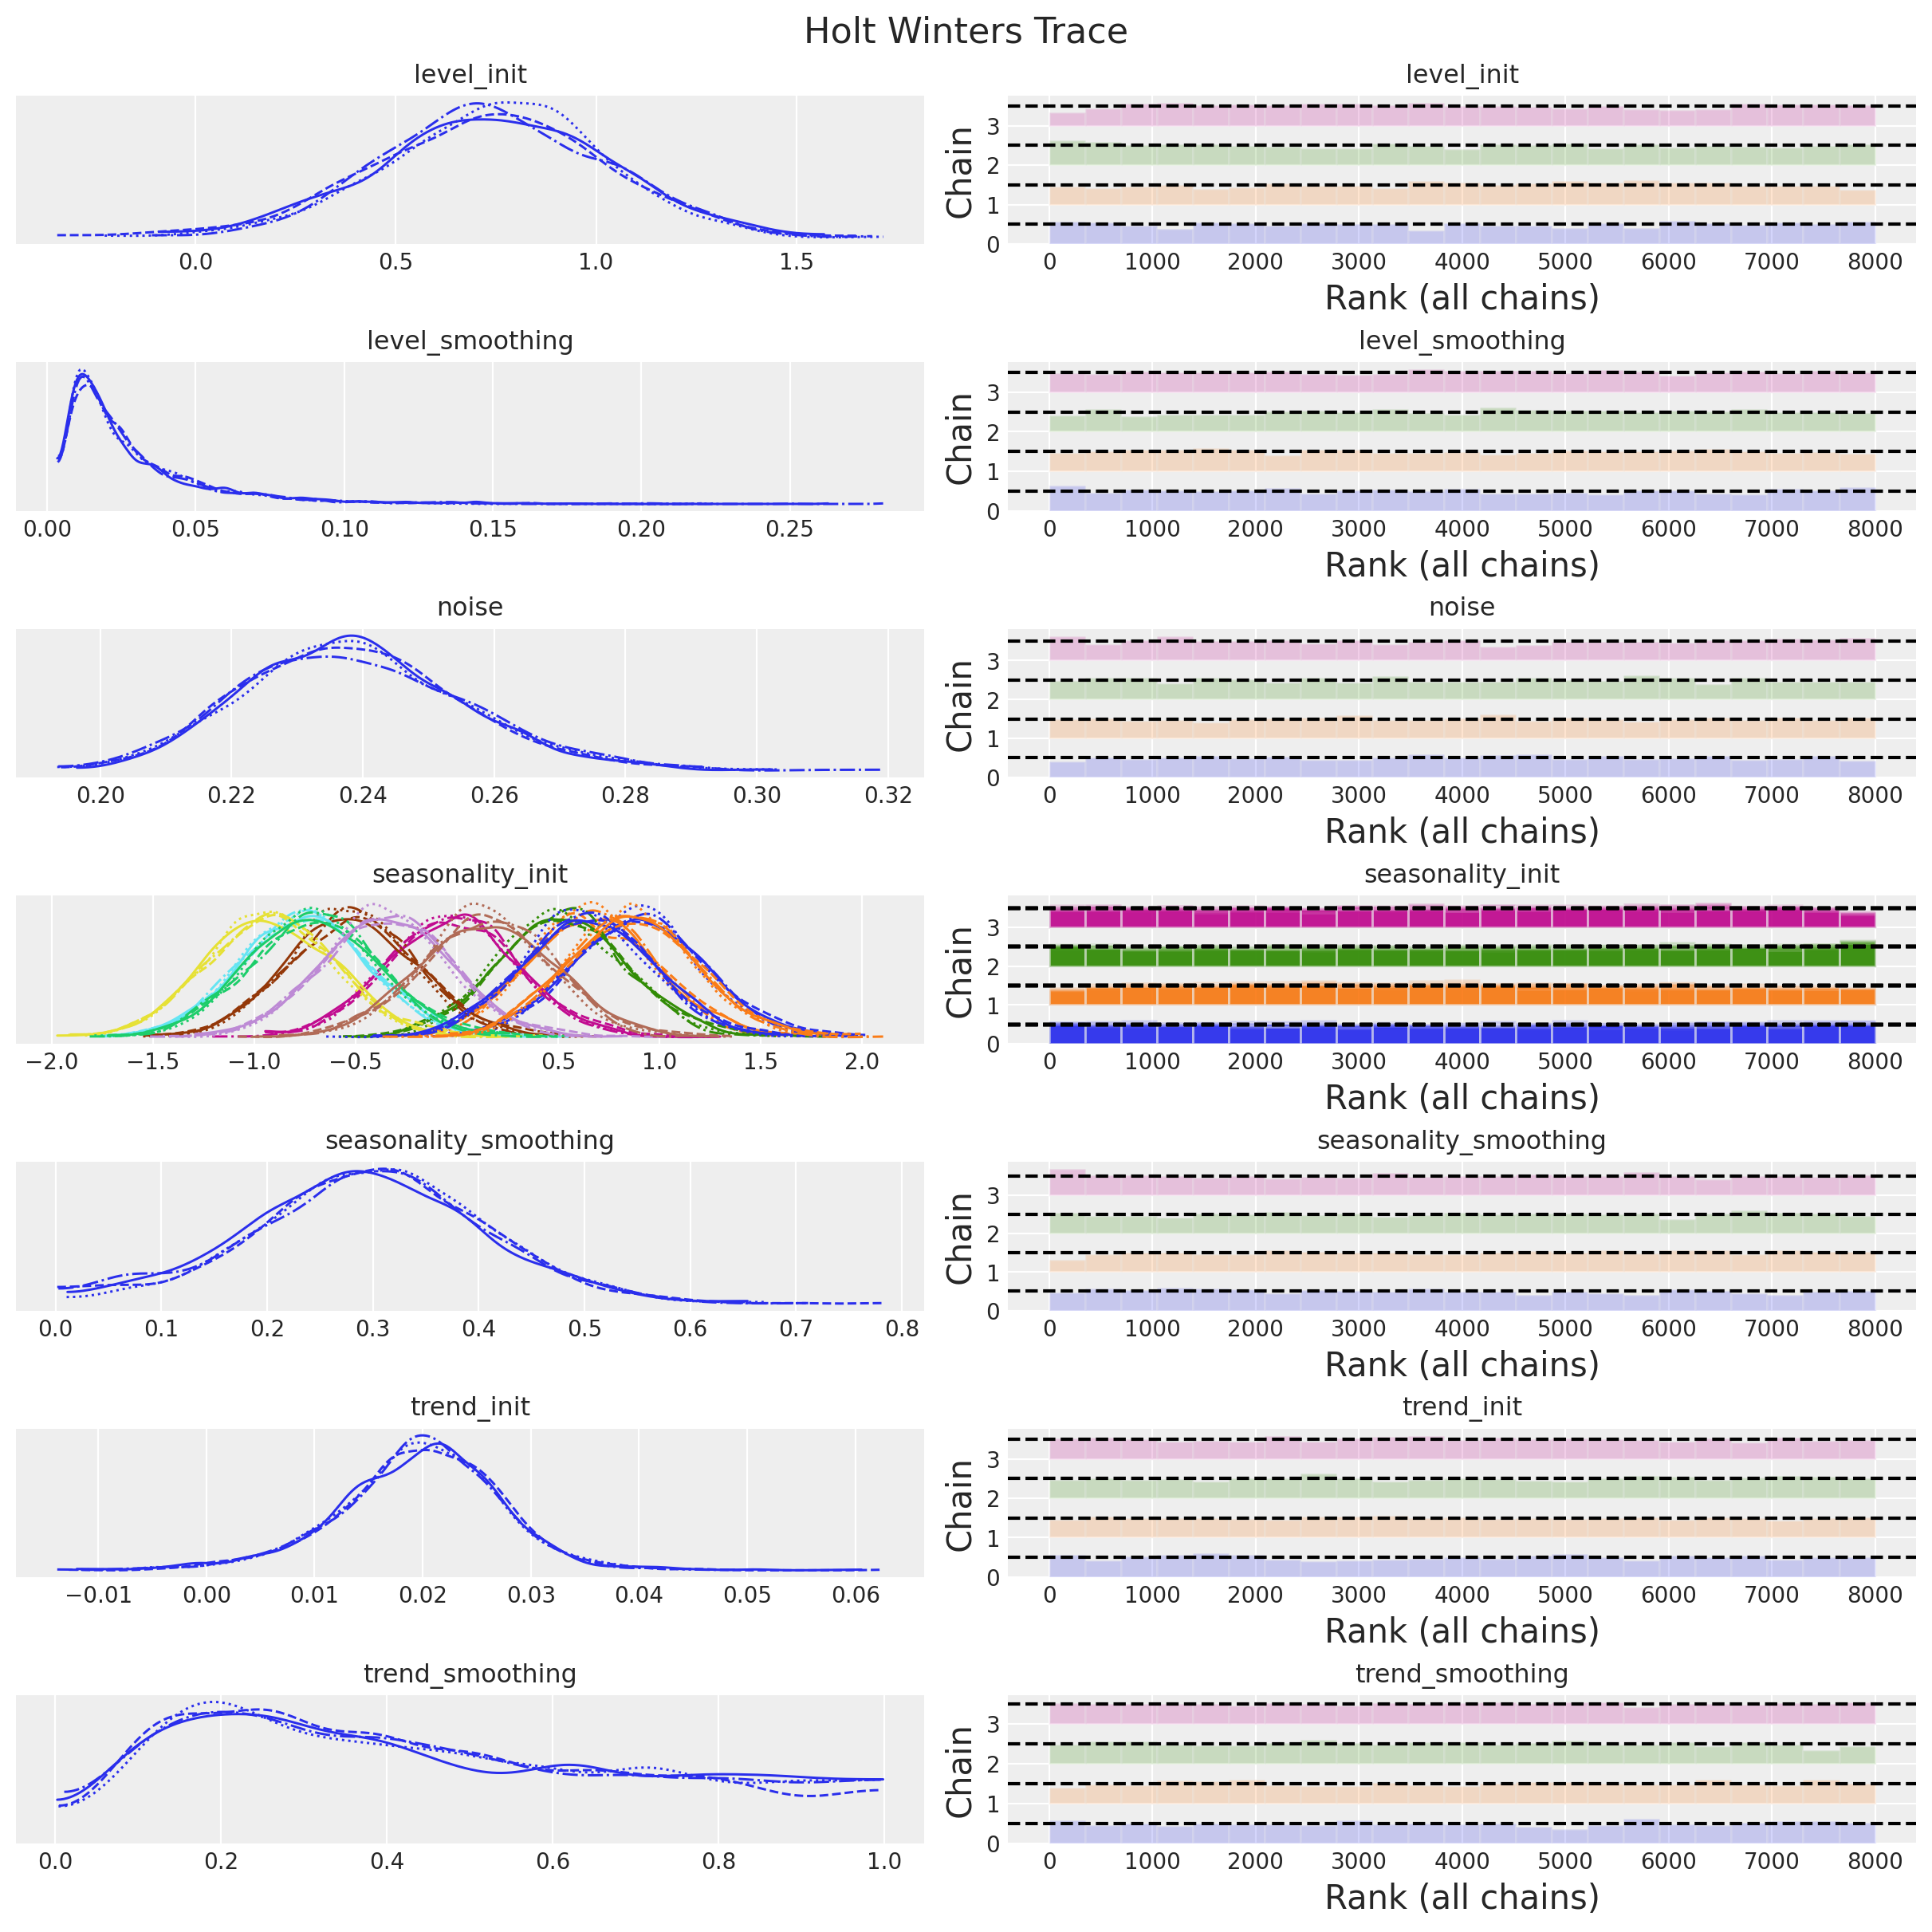

In [ ]:
axes = az.plot_trace(
    data=holt_winters_idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 12), "layout": "constrained"},
)
plt.gcf().suptitle("Holt Winters Trace", fontsize=16)

### Forecast

In [ ]:
rng_key, rng_subkey = random.split(key=rng_key)
holt_winters_forecast = forecast(
    rng_subkey,
    holt_winters_model,
    holt_winters_mcmc.get_samples(),
    y_train,
    n_seasons,
    y_test.size,
)

holt_winters_posterior_predictive = az.from_numpyro(
    posterior_predictive=holt_winters_forecast,
    coords={"t": range(n_train, n)},
    dims={"y_forecast": ["t"]},
)